In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sinkhorn_knopp import sinkhorn_knopp as skp
import plotly.express as px

np.random.seed(3)
import networkx as nx
from tqdm import tqdm

from tqdm.notebook import trange

# Données, paramètres globaux et fonctions de bases 

## Ouverture des données 

In [39]:
with open("first_database.pkl","rb") as f:
    x,y = pickle.load(f)

## Analyse des données 

In [6]:
print(x.shape)
print(y.shape)

(1000000,)
(1000000,)


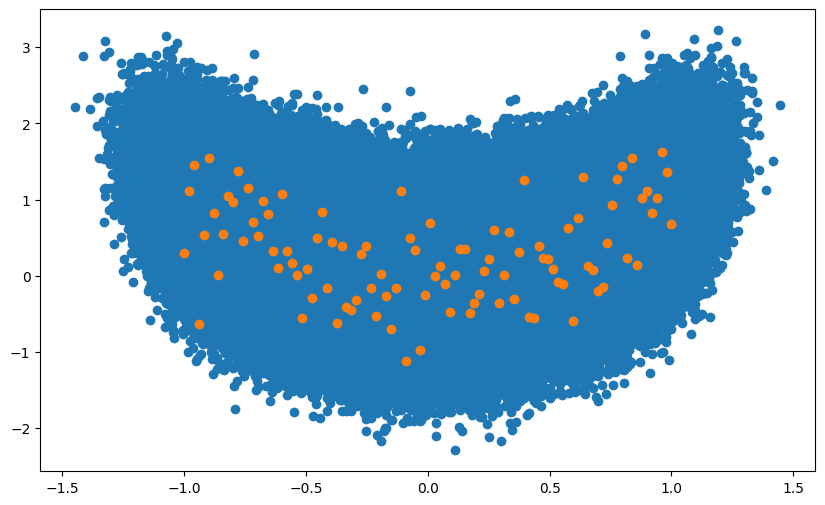

In [40]:
plt.figure(figsize=(10,6))
plt.scatter(x,y)
plt.scatter(x[:100],y[:100],label="100")

## Fonctions utiles 

In [41]:
def k(x,x_i):
    return np.exp(-np.linalg.norm(x-x_i)**2)

In [42]:
def K(N,M,x): # ancienne méthode pour calculer la matrice K
    """
    N : ensemble d'indice pour les colonnes
    M : ensemble des indices M
    x: données
    """
    K=np.zeros((len(N),len(M)))
    for i in range(len(N)):
        for j in range(len(M)):
          K[i,j]=k(x[N[i]],x[M[j]])

    return K




## Paramètres

In [43]:

# paramètres pour la simulation


n = 100
m = 10
a = 5


N=np.arange(100) # indice pour la simulation (échantillion)

np.random.shuffle(N)
A = np.array_split(N, a) # split dans les agents aléatoire grâce au shuffle



M = np.random.choice(N,size=m, replace=False) # sélection de M

alpha0=np.zeros((a,m)) # sert d'initialisation pour des algos


sigma=0.5




## Calcul des matrices autrement pour gagner en temps de calcul

In [44]:
K_mm=K(M,M,x)
K_im=np.zeros((N.size,M.size))
for i in range(N.size):
    K_im[i,:]=K([N[i]],M,x)



N_back permet de pouvoir faire une correspondance entre les numéros d'indices et N 

In [45]:
N_back=np.zeros(x.shape[0],dtype="int")
for i in N:
    N_back[i]=np.where(N==i)[0][0]
N_back

array([95, 76, 79, ...,  0,  0,  0])

## calcul des fonctions de bases 

### f_a

In [46]:
# f en utilisant K_mm et N_back : plus rapide

def f_a(alpha,A,sigma,K_mm,K_im,N,y): 
  """
  alpha : vecteur de taille m
  A : matrice qui contient les agents 
  sigma : float
  K_mm matrice déjà calculée
  K_im : matrice déjà calculée
  N : ensemble des indices
  y : data y 
  """
  res=0
  for A_elem in A:
    terme1=0.1*((alpha.transpose()).dot(K_mm).dot(alpha))
    somme=0
    for i in A_elem:
        # somme+=np.linalg.norm(y[i]-(K_im[np.where(N==i)[0],:]).dot(alpha))**2
        somme+=(y[i]-(K_im[N_back[i],:]).dot(alpha))**2
    terme2=somme/(2*sigma*sigma)

    res+= terme1+terme2
  return res




In [47]:
# f en utilisant K_mm  mais pas N_back: un peu moins rapide

def f_a_bis(alpha,A_elem,sigma,K_mm,K_im,N,y): 
  res=0
  # for A_elem in A:
  terme1=0.1*((alpha.T)@(K_mm)@(alpha))
  somme=0
  for i in A_elem:
      somme+=(y[i]-(K_im[N_back[i],:]).dot(alpha))**2
  terme2=somme/(2*sigma*sigma)

  res+= terme1+terme2
  return res

In [48]:
# calcul de f sans utiliser K_mm

def f_a_copie(alpha,A,sigma,M,x,y): 
  res=0
  for A_elem in A:
    terme1=0.1*((alpha.transpose()).dot(K(M,M,x)).dot(alpha))
    somme=0
    for i in A_elem:
        somme+=np.linalg.norm(y[i]-(K([i],M,x)).dot(alpha))**2
    terme2=somme/(2*sigma*sigma)

    res+= terme1+terme2
  return res



### grad_f_a

In [49]:
# grad_f en utilisant K_mm et N_back : plus rapide

def grad_f_a(alpha,A,sigma,K_mm,K_im,N,y): 
  terme1=0.2*(K_mm.dot(alpha))
  
  somme=0
  for i in A:
    somme+= ((y[i]-(K_im[np.where(N==i)[0],:]).dot(alpha))*K_im[np.where(N==i)[0],:]).flatten()
    

  return terme1-somme/(sigma*sigma)

grad_f_a(np.ones(10),N,sigma,K_mm,K_im,N,y)

array([1468.02310962, 1522.5989604 , 1912.03733167, 1983.55248753,
       2058.79801679, 1613.72486469, 1970.99576728, 2059.67039291,
       1871.10676959, 1979.69404712])

In [50]:
# f en utilisant sans K_mm et N_back : moins rapide

def grad_f_a_copie(alpha,A,sigma,M,x,y): 
  terme1=0.2*(K_mm.dot(alpha))
  
  somme=0
  for i in A:
    somme+= ((y[i]-K([i],M,x).dot(alpha))*K([i],M,x)).flatten()

  return terme1-somme/(sigma*sigma)

grad_f_a_copie(np.ones(10),N,sigma,M,x,y)

array([1468.02310962, 1522.5989604 , 1912.03733167, 1983.55248753,
       2058.79801679, 1613.72486469, 1970.99576728, 2059.67039291,
       1871.10676959, 1979.69404712])

### Calcul du hessien

Fonction du hessien avec une légère correction

In [51]:
# hessien avec légère correction

def hessien (A,sigma,M,x):
    res=K(M,M,x)+0.001*np.eye(m)
    for i in A:
        res-=K([i],M,x)@K([i],M,x).T/(sigma**2)
    return res

valeurs propres du hessien 

In [52]:
hess=hessien(A,sigma,M,x)
np.linalg.eig(hess)[0]

array([7.55583524e+00, 2.07553186e+00, 3.29099348e-01, 3.60462753e-02,
       2.48061878e-03, 1.02798426e-03, 1.00110998e-03, 1.00003789e-03,
       1.00000002e-03, 1.00000000e-03])

## calcul $\alpha^*$

### Calcul exacte pour toutes les données mais très long 

In [53]:

if False:
    ind_n = np.arange(x.shape[0])
    best_alpha=np.linalg.solve(K(M,M,x)+(K(ind_n,M,x).T)@K(ind_n,M,x)/(sigma**2)+0.001*np.eye(m),K(ind_n,M,x).T @ y/(sigma**2))
    best_alpha

### Calcul via scipy : -> mauvais

In [54]:
from scipy.optimize import minimize


def f_test(alpha):
  sigma=0.5
  res=0
  
  return f_a(alpha,A,sigma,K_mm,K_im,N,y)

In [55]:
res=minimize(f_test,np.zeros(m),method='Powell')
alpha_star_bis=res.x
res.fun


53.09158932742719

### Calcul avec algèbre linéaire avec régularisation pour seulement les A points sélectionnés

C'est le alpha qui va être utilisé par la suite

In [56]:
def calcul_alpha_star():
    mat_f=K_mm.copy()+0.001*np.eye(m)
    vec_f=np.zeros(m)
    for A_elem in A:
        for i in A_elem: 
            mat_f+=(K_im[N_back[i],:].reshape((-1,1))@K_im[N_back[i],:].reshape((1,-1)))/(sigma*sigma)
            vec_f+=y[i]*K_im[N_back[i],:]/(sigma*sigma)
    print("Rang de la matrice à inverser :",np.linalg.matrix_rank(mat_f))
    return np.linalg.solve(mat_f,vec_f)
    
alpha_star=calcul_alpha_star()



Rang de la matrice à inverser : 10


In [24]:
print("Valeur approchée de l'objectif")
f_a(alpha_star,A,sigma,K_mm,K_im,N,y)

Valeur approchée de l'objectif


52.5857151623271

In [25]:
alpha_star

array([ 5.57431178, -0.74552735, -5.5057621 , -2.66925238,  5.40268604,
        5.27371965, -3.39936232,  5.77187912, -8.15737221, -0.11119509])

## Matrice W

### vérification de la double stochasticité

In [26]:
def is_double_sto(A):
  """
  Vérifie si A est doublement stochastique
  """
  if A.shape[0]!=A.shape[1]:
    print("Mauvaise forme")
    return False
  reponse=True
  ligne = np.zeros(A.shape[0])
  col = np.zeros(A.shape[0])
  for i in range (A.shape[0]):
    ligne[i] = A[i,:].sum()
    if not np.isclose(A[i,:].sum(),1): 
      reponse=False

    col[i] = A[:,i].sum()
    if not np.isclose(A[:,i].sum(),1,rtol=0.01): 
      reponse = False
  if reponse == False:
    print("ligne : ",ligne)
    print("Colonne : ",col) 

  return reponse
    

In [27]:
W = np.ones((a,a))/5
is_double_sto(W)

True

### Fonction qui crée matrice doublement stochastique

In [28]:
def create_W(liste,taille,auto=True):
    """
    liste des arrêtes
    taille du graphe
    auto : bool : diagonale mise à 1
    """
    sk = skp.SinkhornKnopp()
    if auto==True:
        res=np.eye(taille)
    else:
        res=np.zeros((taille,taille))
    for i,j in liste: 
        res[i,j]=1
        res[j,i]=1
    return sk.fit(res)


In [29]:
ind=[(0,1),(2,4),(1,3),(0,4)]


print(create_W(ind,5))
is_double_sto(create_W(ind,5))

[[0.36445888 0.31777056 0.         0.         0.31777056]
 [0.31737259 0.27671617 0.         0.40591124 0.        ]
 [0.         0.         0.59463073 0.         0.40536927]
 [0.         0.40536927 0.         0.59463073 0.        ]
 [0.31737259 0.         0.40591124 0.         0.27671617]]


True

## visualisation du graphe

In [30]:
def visual_graph(liste_indice):
    G = nx.Graph()
    for i,j in liste_indice:
        G.add_edge(i+1, j+1)
    

    # explicitly set positions
    pos = {1: (-1, 0), 2: (np.cos(3*np.pi/5), np.sin(3*np.pi/5)), 3: (np.cos(np.pi/5), np.sin(np.pi/5))
           , 4: (np.cos(-np.pi/5), np.sin(-np.pi/5)), 5: (np.cos(-3*np.pi/5),np.sin(-3*np.pi/5))}

    options = {
    "font_size": 36,
    "node_size": 3000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    
    "width": 1,
    }
    nx.draw_networkx(G, pos, **options)

    # Set margins for the axes so that nodes aren't clipped
    ax = plt.gca()
    ax.margins(0.1)
    plt.axis("off")
    plt.show()


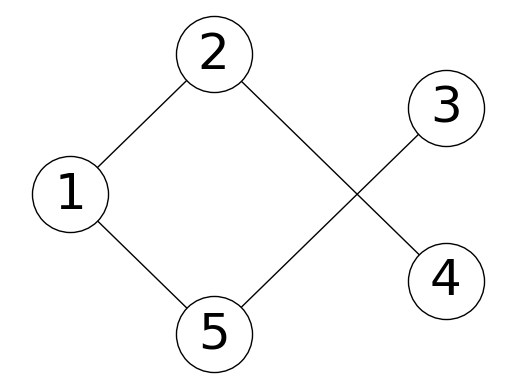

In [ ]:
visual_graph(ind)

# Part I

# DGD

In [35]:
def DGD(alpha0, W, A, M,x,y ,alpha_star,sigma=0.5,  lr=0.1, tol=1e-05,n_iter_max=1000):
    """
    alpha0 : initialisation pour tous les i (matrice) chaque colonne = i
    W : matrice deoublement sto des interactions
    A : matrice des agents
    M : indices des m points
    x : 
    y : 
    alpha_star : meilleur alpha
    lr : pas de la descente (pour l'instant constant)
    tol : amélioration minimale
    n_iter_max : nombre d'itération maximum
    """
    if not is_double_sto(W):
      sys.exit("Matrice W non doublement stochastique")
    # initialisation
    alpha = np.copy(alpha0)
    
    n_iter = 0
    # ecart = [np.linalg.norm(alpha.mean(axis=0)-alpha_star)]
    # ecart_f=[np.abs(f_a(alpha_star,A,sigma,K_mm,K_im,N,y)-f_a(alpha.mean(axis=0),A,sigma,K_mm,K_im,N,y))]
    alpha_liste=[alpha]
    f_liste=[f_a(alpha.mean(axis=0),A,sigma,K_mm,K_im,N,y)]

    for n_iter in tqdm(range(n_iter_max)):
      alpha_pred=np.copy(alpha)

      # calcul du alpha suivant
      alpha=W.dot(alpha_pred)
      
      for a in range(len(A)):
        
        alpha[a,:]-=lr*grad_f_a(alpha_pred[a,:],A[a],sigma,K_mm,K_im,N,y)
        #print(lr*grad_f_a(alpha_pred[a,:],A[a],sigma,M,x,y))

      
      #n_iter+=1
      
      
      # ecart.append(np.linalg.norm(alpha.mean(axis=0)-alpha_star))
      # ecart_f.append(np.abs(f_a(alpha_star,A,sigma,K_mm,K_im,N,y)-f_a(alpha.mean(axis=0),A,sigma,K_mm,K_im,N,y)))
      alpha_mean=alpha.mean(axis=0)
      alpha_liste.append(alpha)
      f_liste.append(f_a(alpha_mean,A,sigma,K_mm,K_im,N,y))
      # if n_iter > n_iter_max: 
      #   print("Arrêt par itértion")
      #   print("Nombre itération : ",n_iter)
      #   print("Ecart : ", np.linalg.norm(alpha-alpha_pred))
      #   break
      
      
    
    return alpha,alpha_liste,f_liste
      

        
      
      


In [ ]:
def DGD_copie(alpha0, W, A, M,x,y ,alpha_star,sigma=0.5,  lr=0.1, tol=1e-05,n_iter_max=1000):
    """
    alpha0 : initialisation pour tous les i (matrice) chaque colonne = i
    W : matrice deoublement sto des interactions
    A : matrice des agents
    M : indices des m points
    x : 
    y : 
    alpha_star : meilleur alpha
    lr : pas de la descente (pour l'instant constant)
    tol : amélioration minimale
    n_iter_max : nombre d'itération maximum
    """
    if not is_double_sto(W):
      sys.exit("Matrice W non doublement stochastique")
    # initialisation
    alpha = np.copy(alpha0)
    
    n_iter = 0
    ecart = [np.linalg.norm(alpha.mean(axis=0)-alpha_star)]
    ecart_f=[np.abs(f_a(alpha_star,A,sigma,M,x,y)-f_a(alpha.mean(axis=0),A,sigma,M,x,y))]
    while True:
      alpha_pred=np.copy(alpha)

      # calcul du alpha suivant
      alpha=W.dot(alpha_pred)
      
      for a in range(len(A)):
        for j in range(5): 
          
          alpha[a,:]-=lr*grad_f_a(alpha_pred[a,:],A[a],sigma,M,x,y)
        
      
      n_iter+=1
      
      ecart.append(np.linalg.norm(alpha.mean(axis=0)-alpha_star))
      ecart_f.append(np.abs(f_a(alpha_star,A,sigma,M,x,y)-f_a(alpha.mean(axis=0),A,sigma,M,x,y)))

      if n_iter > n_iter_max: 
        print("Arrêt par itértion")
        print("Nombre itération : ",n_iter)
        print("Ecart : ", np.linalg.norm(alpha-alpha_pred))
        break
      
      
    
    return alpha,ecart,ecart_f
      

        
      
      


## Paramètres pour la simulation DGD


[[0.36445888 0.31777056 0.         0.         0.31777056]
 [0.31737259 0.27671617 0.         0.40591124 0.        ]
 [0.         0.         0.59463073 0.         0.40536927]
 [0.         0.40536927 0.         0.59463073 0.        ]
 [0.31737259 0.         0.40591124 0.         0.27671617]]


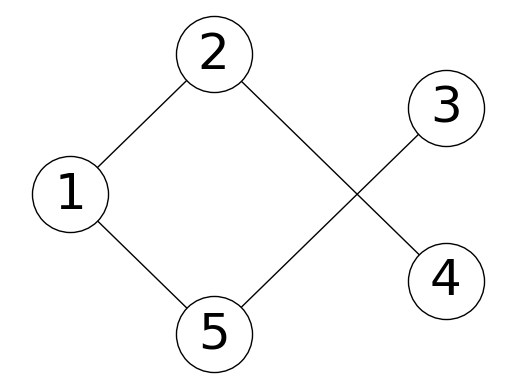

In [57]:
ind=[(0,1),(2,4),(1,3),(0,4)]


W=create_W(ind,5)
print(W)
visual_graph(ind)

In [58]:
# calcul L_A

L_a=np.zeros(len(A))
i=0
for A_elem in A: 
    L_a[i]=np.max(np.abs(np.linalg.eigvals(hessien(A_elem,sigma,M,x))))
    i+=1

L=max(L_a)
print("L",L)
print("1/L",1/L)

L 4632.1645116223235
1/L 0.00021588179726582507


In [59]:
1/L

0.00021588179726582507

## Simulation

In [60]:
alpha_dgd,liste_alpha_dgd,liste_f_dgd=DGD(alpha0=alpha0,W=W,A=A,M=M,lr=0.95/L,x=x,y=y,alpha_star=alpha_star,n_iter_max=100000)

resultat_dgd=alpha_dgd.mean(axis=0)
resultat_dgd

  2%|▏         | 1754/100000 [00:02<01:58, 830.07it/s]


KeyboardInterrupt: 

In [61]:
W_eigen_vals=np.sort(np.linalg.eigvals(W))[::-1]
W_eigen_vals

array([ 1.00000000e+00,  8.71346906e-01,  4.83744513e-01, -1.11022302e-16,
       -2.47938729e-01])

In [62]:
gamma=max(np.abs(W_eigen_vals[1]),np.abs(W_eigen_vals[-1]))
gamma

0.8713469063305146

In [63]:
conv_rate_dgd = (0.95/L)/(1-gamma)
conv_rate_dgd

0.001594114074935592

In [64]:
print(f_a_copie(resultat_dgd,A,0.5,M,x,y))

f_a_copie(alpha_star,A,0.5,M,x,y)

NameError: name 'resultat_dgd' is not defined

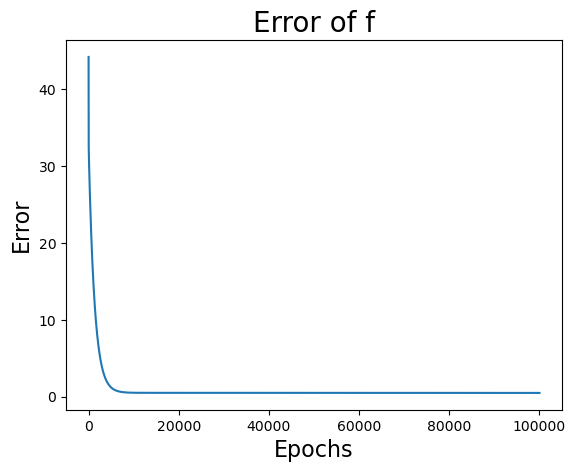

In [80]:
plt.figure()
plt.plot(np.array(liste_f_dgd)-f_a_copie(alpha_star,A,0.5,M,x,y))
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("Error",fontsize=16)
plt.title("Error of f",fontsize=20)
plt.show()


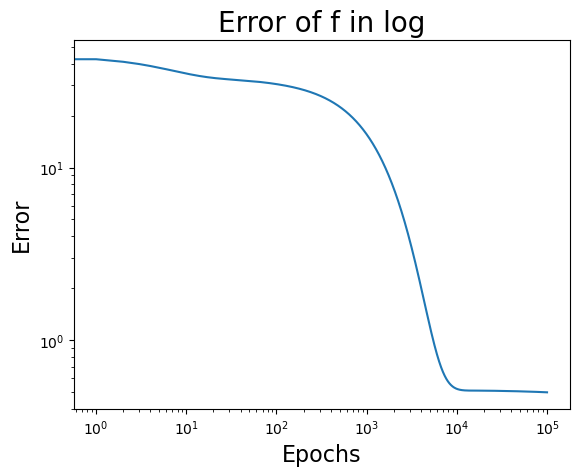

In [81]:
plt.figure()
plt.loglog(np.array(liste_f_dgd)-f_a_copie(alpha_star,A,0.5,M,x,y))
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("Error",fontsize=16)
plt.title("Error of f in log",fontsize=20)
plt.show()


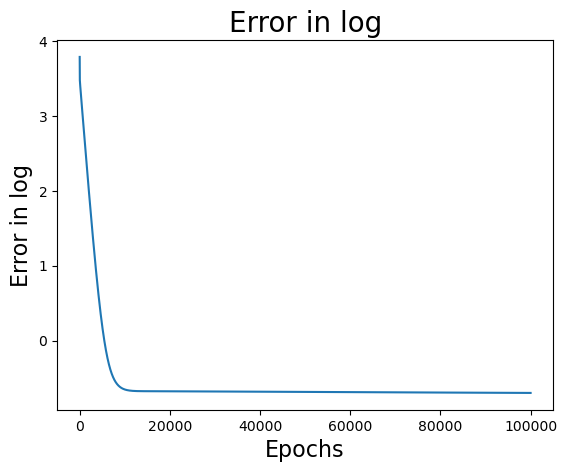

In [82]:
plt.figure()
plt.plot(np.log(np.array(liste_f_dgd)-f_a_copie(alpha_star,A,0.5,M,x,y)))
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("Error in log",fontsize=16)
plt.title("Error in log",fontsize=20)
plt.show()


In [104]:
liste_alpha_dgd[i].mean(axis=0)

array([0.01036882, 0.01037666, 0.00919579, 0.00907095, 0.00903038,
       0.00958189, 0.00909205, 0.00904664, 0.0098968 , 0.00952822])

In [105]:
ecart_alpha_dgd=np.zeros((len(liste_alpha_dgd),len(A)))
for i in range(len(liste_alpha_dgd)):
    for j in range(len(A)):
        ecart_alpha_dgd[i,j]=np.linalg.norm(liste_alpha_dgd[i].mean(axis=0)-liste_alpha_dgd[i][j,:])



Text(0.5, 1.0, 'DGD')

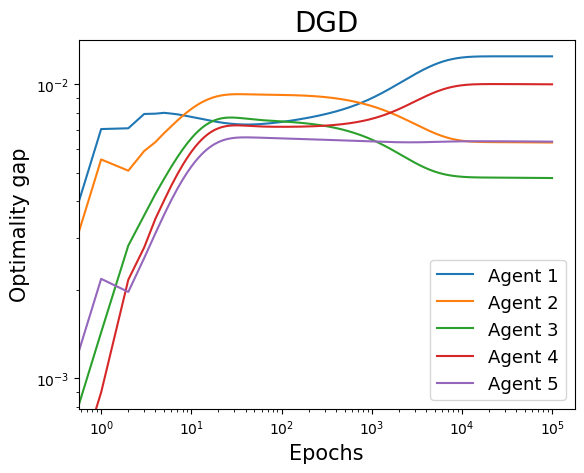

In [107]:
plt.figure()
for i in range(len(A)):
    plt.loglog(ecart_alpha_dgd[:,i],label="Agent "+str(i+1))
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Optimality gap",fontsize=15)
plt.legend(fontsize=13)
plt.title("DGD",fontsize=20)

C:\Users\pasta\AppData\Local\Temp\ipykernel_17664\2081806549.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(ecart_alpha_dgd[:,i]),label="Agent "+str(i+1))


Text(0.5, 1.0, 'DGD log plot')

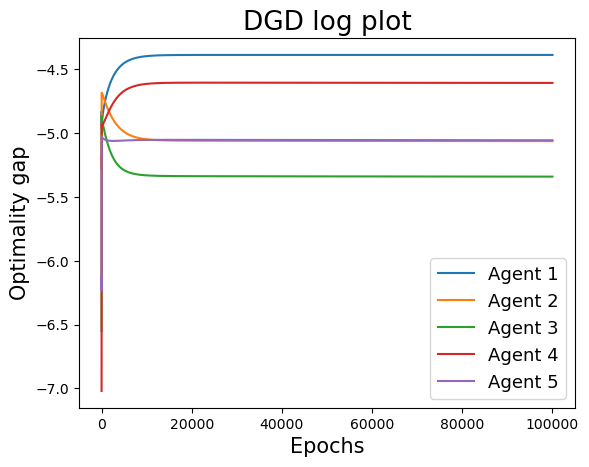

In [108]:
plt.figure()
for i in range(len(A)):
    plt.plot(np.log(ecart_alpha_dgd[:,i]),label="Agent "+str(i+1))
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Optimality gap",fontsize=15)
plt.legend(fontsize=13)
plt.title("DGD log plot",fontsize=19)

Text(0.5, 1.0, 'DGD')

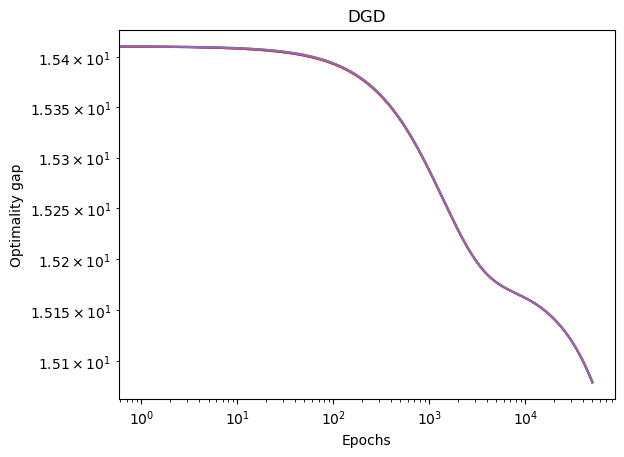

In [45]:
plt.figure()
for i in range(len(A)):
    plt.plot((ecart_alpha_dgd[:,i]),label="Agent "+str(i+1))
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Optimality gap",fontsize=15)
plt.legend(fontsize=13)
plt.title("DGD log plot",fontsize=19)

Convergence graph

In [46]:
print(f_a(resultat_dgd,A,sigma,K_mm,K_im,N,y)-f_a(alpha_star,A,sigma,K_mm,K_im,N,y))

0.5031375284410728


Different W

[[0.  0.5 0.  0.  0.5]
 [0.5 0.  0.5 0.  0. ]
 [0.  0.5 0.  0.5 0. ]
 [0.  0.  0.5 0.  0.5]
 [0.5 0.  0.  0.5 0. ]]


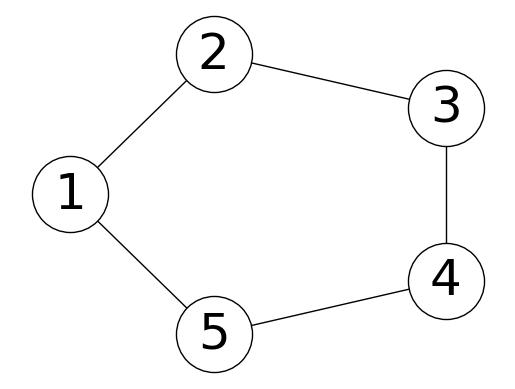

In [79]:
ind0=[(0,1),(1,2),(2,3),(3,4),(4,0)]


W0=create_W(ind0,5,auto=False)
print(W0)
visual_graph(ind0)

[[0.33333333 0.33333333 0.         0.         0.33333333]
 [0.33333333 0.33333333 0.33333333 0.         0.        ]
 [0.         0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.33333333 0.33333333 0.33333333]
 [0.33333333 0.         0.         0.33333333 0.33333333]]


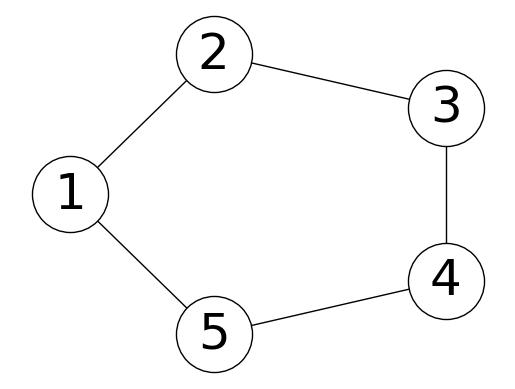

In [80]:
ind1=[(0,1),(1,2),(2,3),(3,4),(4,0)]


W1=create_W(ind1,5)
print(W1)
visual_graph(ind1)

[[0.22145122 0.29874383 0.         0.23990248 0.23990248]
 [0.29859413 0.40281174 0.29859413 0.         0.        ]
 [0.         0.29874383 0.22145122 0.23990248 0.23990248]
 [0.24000157 0.         0.24000157 0.25999843 0.25999843]
 [0.24000157 0.         0.24000157 0.25999843 0.25999843]]


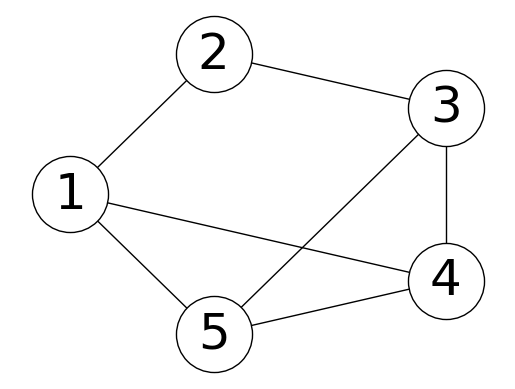

In [81]:
ind2=[(0,1),(1,2),(2,3),(3,4),(4,0),(4,2),(0,3)]


W2=create_W(ind2,5)
print(W2)
visual_graph(ind2)

[[0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]]


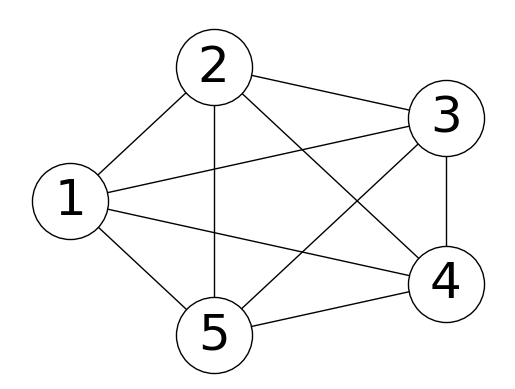

In [82]:
ind3=[(i,j) for i in range(5) for j in range(5)]


W3=create_W(ind3,5)
print(W3)
visual_graph(ind3)

In [51]:
W_liste =[W0,W1,W2,W3]
alpha_dgd_comp=[]
f_dgd_comp=[]
for W_mat in W_liste: 
    
    alpha_dgd_w,liste_alpha_dgd_w,liste_f_dgd_w=DGD(alpha0=alpha0,W=W_mat,A=A,M=M,lr=0.95/L,x=x,y=y,alpha_star=alpha_star,n_iter_max=20000)
    alpha_dgd_comp.append(liste_alpha_dgd_w)
    f_dgd_comp.append(liste_f_dgd_w)
    #ecart.append(np.abs(f_a(alpha.mean(axis=0),A,sigma,K_mm,K_im,N,y)-f_a(alpha_star,A,sigma,K_mm,K_im,N,y)))
    

100%|██████████| 20000/20000 [00:35<00:00, 559.96it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[]

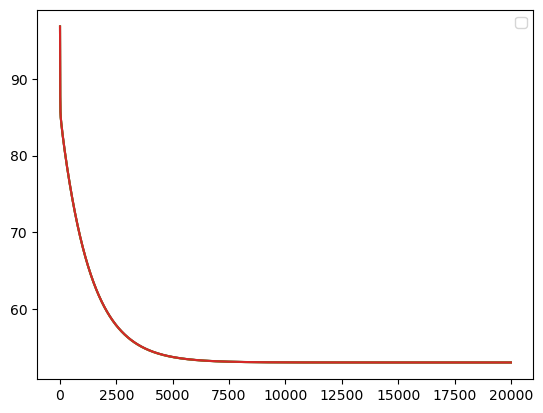

In [52]:
plt.figure()
for i in range(len(W_liste)):
    plt.plot(f_dgd_comp[i])
plt.legend()
plt.plot()

In [75]:
len(f_dgd_comp)

4

[]

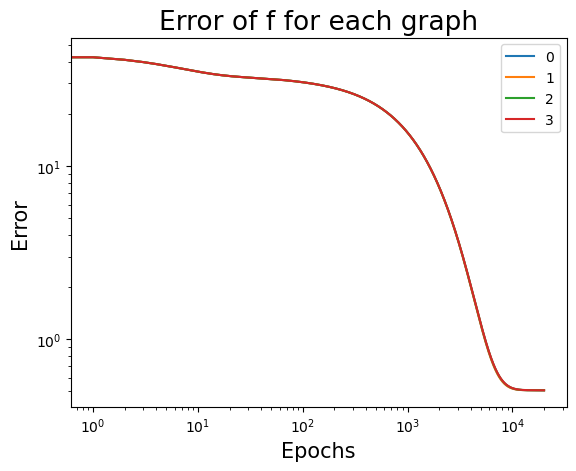

In [98]:
plt.figure()
for i in range(len(f_dgd_comp)):
    plt.loglog(f_dgd_comp[i]-f_a(alpha_star,A,sigma,K_mm,K_im,N,y),label=str(i))
plt.legend()
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Error",fontsize=15)
plt.title("Error of f for each graph",fontsize=19)
plt.plot()

[]

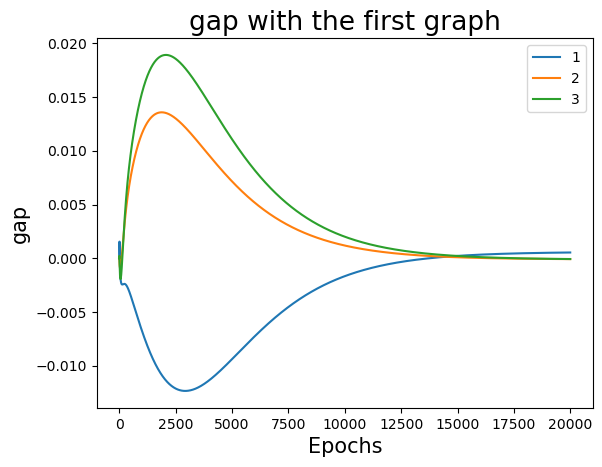

In [85]:
plt.figure()
for i in range(1,len(f_dgd_comp)):
    plt.plot(np.array(f_dgd_comp[i])-np.array(f_dgd_comp[0]),label=str(i))
plt.legend()
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("gap",fontsize=15)
plt.title("gap with the first graph",fontsize=19)
plt.plot()

Difference of step

In [87]:
dgd_step_liste_alpha=[]
dgd_step_liste_f=[]

for step in step_liste:
    alpha_dgd_step,liste_alpha_dgd_step,liste_f_dgd_step=DGD(alpha0=alpha0,W=W,A=A,M=M,lr=step/L,x=x,y=y,alpha_star=alpha_star,n_iter_max=50000)
    dgd_step_liste_alpha.append(liste_alpha_dgd_step)
    dgd_step_liste_f.append(liste_f_dgd_step)
    

100%|██████████| 50000/50000 [01:36<00:00, 517.52it/s]


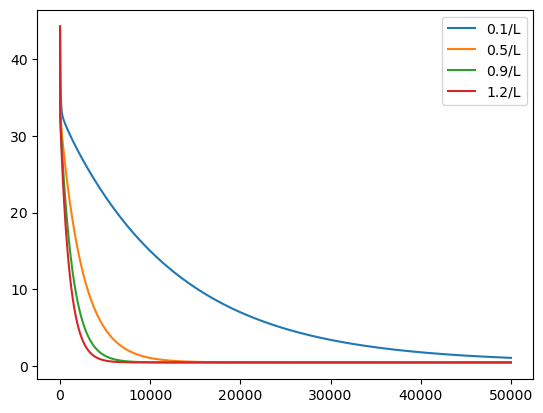

In [91]:
step_liste=[0.1,0.5,0.9,1.2]
plt.figure()
for i in range(len(dgd_step_liste_alpha)):
    plt.plot(dgd_step_liste_f[i]-f_a(alpha_star,A,sigma,K_mm,K_im,N,y),label=str(step_liste[i])+"/L")
plt.legend()


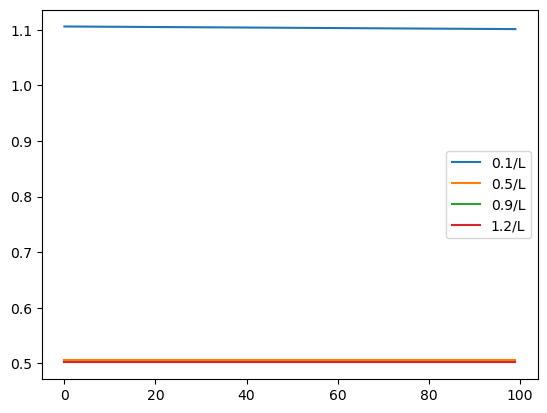

In [96]:
step_liste=[0.1,0.5,0.9,1.2]
plt.figure()
for i in range(len(dgd_step_liste_alpha)):
    plt.plot(np.array(dgd_step_liste_f[i]-f_a(alpha_star,A,sigma,K_mm,K_im,N,y))[-100:],label=str(step_liste[i])+"/L")
plt.legend()

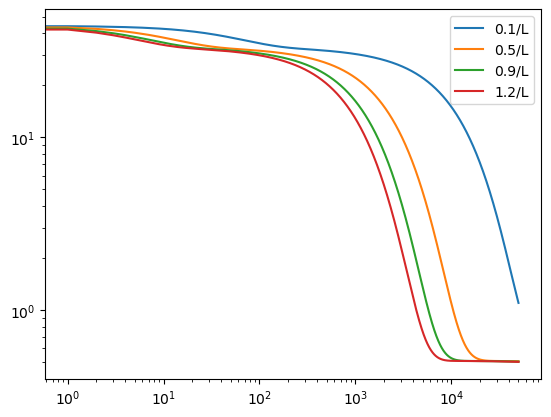

In [92]:
step_liste=[0.1,0.5,0.9,1.2]
plt.figure()
for i in range(len(dgd_step_liste_alpha)):
    plt.loglog(dgd_step_liste_f[i]-f_a(alpha_star,A,sigma,K_mm,K_im,N,y),label=str(step_liste[i])+"/L")
plt.legend()

Visualisation fonction

In [55]:
def f(x_prime,M,alpha):
    res=np.zeros(x_prime.size)
    for i in range(x_prime.size):
        for j in range(len(M)):
            res[i]+=alpha[j]*k(x_prime[i],x[M[j]])
    
    return res



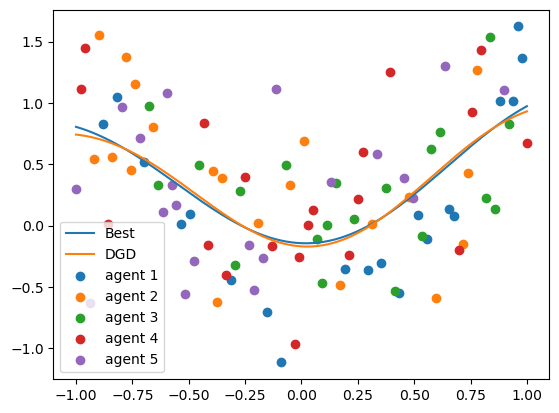

In [56]:
s=250
x_prime=np.linspace(-1,1,s)

plt.figure()
plt.plot(x_prime,f(x_prime,M,alpha_star),label="Best")
plt.plot(x_prime,f(x_prime,M,resultat_dgd),label="DGD")
i=1
for A_elem in A : 
    plt.scatter(x[A_elem],y[A_elem],label="agent "+str(i))
    i+=1
plt.legend()

In [131]:
alpha_dgd_false,liste_alpha_dgd_false,liste_f_dgd_false=DGD(alpha0=alpha0,W=W,A=A,M=M,lr=1/L,x=x,y=y,alpha_star=alpha_star,n_iter_max=10000)
plt.plot(liste_f_dgd_false)


ligne :  [5. 5. 5. 5. 5.]
Colonne :  [5. 5. 5. 5. 5.]


SystemExit: Matrice W non doublement stochastique

c:\Users\pasta\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [124]:
print(liste_f_dgd_false[-1])
liste_f_dgd[-1]

53.05123776200219


53.08225853973911

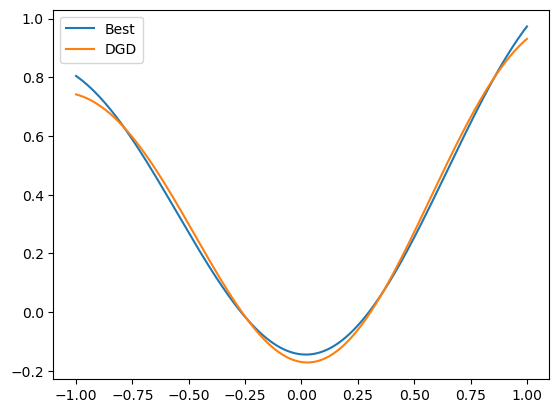

In [57]:
s=250
x_prime=np.linspace(-1,1,s)

plt.figure()
plt.plot(x_prime,f(x_prime,M,alpha_star),label="Best")
plt.plot(x_prime,f(x_prime,M,resultat_dgd),label="DGD")
# i=1
# for A_elem in A : 
#     plt.scatter(x[A_elem],y[A_elem],label="agent "+str(i))
#     i+=1
plt.legend()

# gradient tracking

In [58]:
def gradient_tracking(alpha0, W, A, M,x,y ,alpha_star,sigma=0.5,  lr=0.1, tol=1e-05,n_iter_max=1000):
    """
    alpha0 : initialisation pour tous les i (matrice) chaque colonne = i
    W : matrice deoublement sto des interactions
    A : matrice des agents
    M : indices des m points
    x : 
    y : 
    alpha_star : meilleur alpha
    lr : pas de la descente (pour l'instant constant)
    tol : amélioration minimale
    n_iter_max : nombre d'itération maximum
    """
    if not is_double_sto(W):
      sys.exit("Matrice W non doublement stochastique")
    # initialisation
    alpha = np.copy(alpha0)
    g=np.zeros((len(A),M.size))

    for a in range(len(A)):
      #g[a,:]=grad_f_a(alpha0[a,:],A[a],sigma,M,x,y)
      g[a,:]=grad_f_a(alpha0[a,:],A[a],sigma,K_mm,K_im,N,y)
      

    # n_iter = 0
    # ecart = [np.linalg.norm(alpha-alpha_star)]
    # ecart_f = [np.abs(f_a(alpha_star,A,sigma,K_mm,K_im,N,y)-f_a(alpha.mean(axis=0),A,sigma,K_mm,K_im,N,y))]
    alpha_liste=[alpha]
    f_liste=[f_a(alpha.mean(axis=0),A,sigma,K_mm,K_im,N,y)]
    
    # while True:
    for i in tqdm(range(n_iter_max)):
      alpha_pred=np.copy(alpha)

      # calcul du alpha suivant
      alpha=W.dot(alpha_pred)
      
      
      for a in range(len(A)):
        
        alpha[a,:]-=lr*g[a,:]
        
      
      g=W.dot(g)
      
      for a in range(len(A)):
        #g[a,:]+=grad_f_a(alpha[a,:],A[a],sigma,M,x,y)-grad_f_a(alpha_pred[a,:],A[a],sigma,M,x,y)
        g[a,:]+=grad_f_a(alpha[a,:],A[a],sigma,K_mm,K_im,N,y)-grad_f_a(alpha_pred[a,:],A[a],sigma,K_mm,K_im,N,y)

      
      alpha_mean=alpha.mean(axis=0)
      alpha_liste.append(alpha)
      f_liste.append(f_a(alpha_mean,A,sigma,K_mm,K_im,N,y))      
    
    return alpha,alpha_liste,f_liste
      

        
      
      


In [59]:
def gradient_tracking_copie(alpha0, W, A, M,x,y ,alpha_star,sigma=0.5,  lr=0.1, tol=1e-05,n_iter_max=1000):
    """
    alpha0 : initialisation pour tous les i (matrice) chaque colonne = i
    W : matrice deoublement sto des interactions
    A : matrice des agents
    M : indices des m points
    x : 
    y : 
    alpha_star : meilleur alpha
    lr : pas de la descente (pour l'instant constant)
    tol : amélioration minimale
    n_iter_max : nombre d'itération maximum
    """
    if not is_double_sto(W):
      sys.exit("Matrice W non doublement stochastique")
    # initialisation
    alpha = np.copy(alpha0)
    g=np.zeros((len(A),M.size))

    for a in range(len(A)):
      g[a,:]=grad_f_a(alpha0[a,:],A[a],sigma,M,x,y)
      

    n_iter = 0
    ecart = [np.linalg.norm(alpha-alpha_star)]
    while True:
      alpha_pred=np.copy(alpha)

      # calcul du alpha suivant
      alpha=W.dot(alpha_pred)
      
      
      for a in range(len(A)):
        
        alpha[a,:]-=lr*g[a,:]
        #print(lr*grad_f_a(alpha_pred[a,:],A[a],sigma,M,x,y))
      
      g=W.dot(g)
      
      for a in range(len(A)):
        g[a,:]+=grad_f_a(alpha[a,:],A[a],sigma,M,x,y)-grad_f_a(alpha_pred[a,:],A[a],sigma,M,x,y)


      n_iter+=1
      
      ecart.append(np.linalg.norm(alpha-alpha_star))

      if n_iter > n_iter_max: 
        print("Arrêt par itértion")
        print("Nombre itération : ",n_iter)
        print("Ecart : ", np.linalg.norm(alpha-alpha_pred))
        break
      
      elif np.linalg.norm(alpha-alpha_pred) < tol:
        print("Arrêt après trop faible amélioration")
        print("tolérance : ",tol)
        print("Ecart : ", np.linalg.norm(alpha-alpha_pred))
        print("Nombre itération : ",n_iter)
        break
    
    return alpha,ecart,ecart_f
      

        
      
      


In [109]:
alpha_track,ecart_track,ecart_f_track=gradient_tracking(alpha0=alpha0,W=W,A=A,M=M,lr=0.95/L,x=x,y=y,alpha_star=alpha_star,n_iter_max=100000)

100%|██████████| 100000/100000 [06:15<00:00, 266.66it/s]


In [61]:
resultat_track=alpha_track.mean(axis=0)
resultat_track

array([ 1.14668197,  0.97977659,  0.19767097, -0.22962357, -0.78895686,
        1.6921223 , -0.15154796, -0.80999847, -0.22910101, -0.62785998])

In [132]:
ecart_f_track[-1]

53.08092273358804

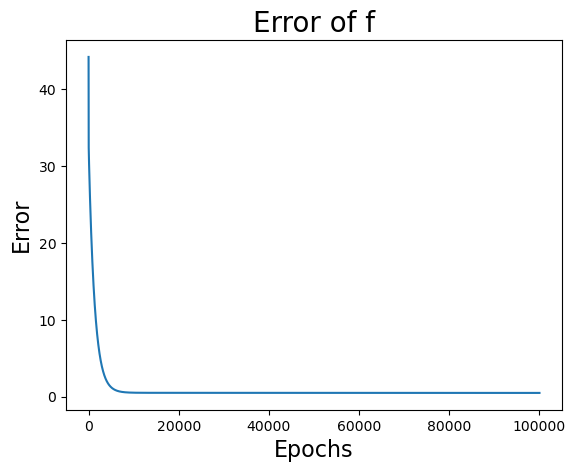

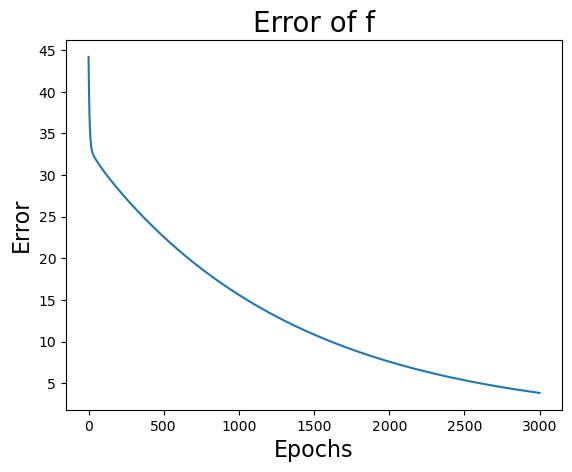

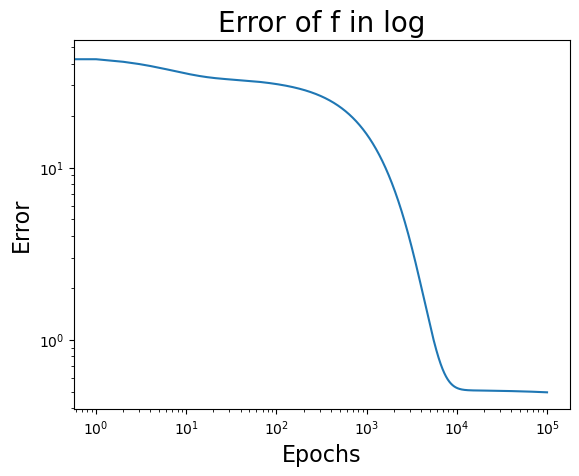

In [156]:
plt.figure()
plt.plot(np.array(ecart_f_track)-f_a_copie(alpha_star,A,0.5,M,x,y))
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("Error",fontsize=16)
plt.title("Error of f",fontsize=20)
plt.savefig("track_f_error.png")
plt.show()


plt.figure()
plt.plot(np.array(ecart_f_track)[:3000]-f_a_copie(alpha_star,A,0.5,M,x,y))
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("Error",fontsize=16)
plt.title("Error of f",fontsize=20)
plt.savefig("track_f_error_zoom.png")
plt.show()

plt.figure()
plt.loglog(np.array(ecart_f_track)-f_a_copie(alpha_star,A,0.5,M,x,y))
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("Error",fontsize=16)
plt.title("Error of f in log",fontsize=20)
plt.savefig("track_f_error_loglog.png")
plt.show()

In [64]:
print(resultat_track)
print(resultat_dgd)
print(alpha_star)

[ 1.14668197  0.97977659  0.19767097 -0.22962357 -0.78895686  1.6921223
 -0.15154796 -0.80999847 -0.22910101 -0.62785998]
[ 1.15643347  0.97331306  0.16384548 -0.25150045 -0.76938878  1.73412904
 -0.17674932 -0.78790841 -0.24361044 -0.61537945]
[ 5.57431178 -0.74552735 -5.5057621  -2.66925238  5.40268603  5.27371965
 -3.39936232  5.77187912 -8.15737221 -0.11119509]


In [159]:
ecart_track

[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[ 2.49420161e-03,  2.36326199e-03, -1.29216058e-04,
         -1.92490693e-04, -6.35519378e-05,  3.00486429e-04,
         -1.85254386e-04, -3.17618149e-05,  1.19586935e-03,
          6.62909497e-04],
        [ 1.66318460e-03,  1.73977823e-03,  5.07562060e-03,
          4.73039064e-03,  3.88997221e-03,  5.72602579e-03,
          4.80244867e-03,  3.81273028e-03,  2.44818388e-03,
          2.87451689e-03],
        [ 3.43627582e-03,  3.45984002e-03,  2.48309528e-03,
          2.61994727e-03,  2.92346283e-03,  2.09512332e-03,
          2.59251093e-03,  2.95088014e-03,  3.41000441e-03,
          3.28003407e-03],
        [ 3.27848185e-03,  3.29756734e-03,  2.51952470e-03,
          2.56109217e-03,  2.73506897e-03,  2.49148050e-03,
       

In [ ]:
ecart_alpha_track=np.zeros((len(ecart_track),len(A)))
for i in range(len(ecart_track)):
    for j in range(len(A)):
        ecart_alpha_track[i,j]=np.linalg.norm(ecart_track[i].mean(axis=0)-ecart_track[i][j,:])

Text(0.5, 1.0, 'Consensus')

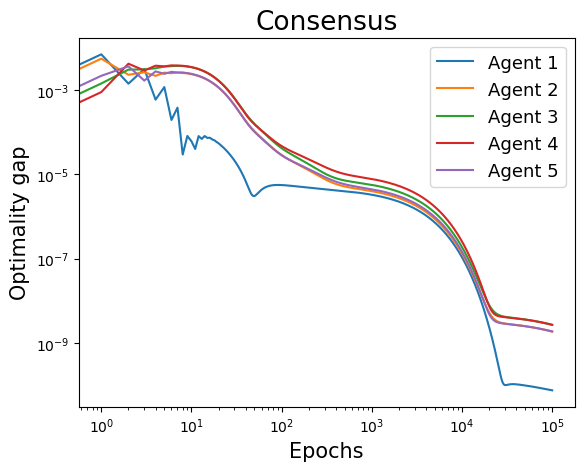

In [163]:
plt.figure()
for i in range(len(A)):
    plt.loglog((ecart_alpha_track[:,i]),label="Agent "+str(i+1))
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Optimality gap",fontsize=15)
plt.legend(fontsize=13)
plt.title("Consensus",fontsize=19)

Text(0.5, 1.0, 'Consensus')

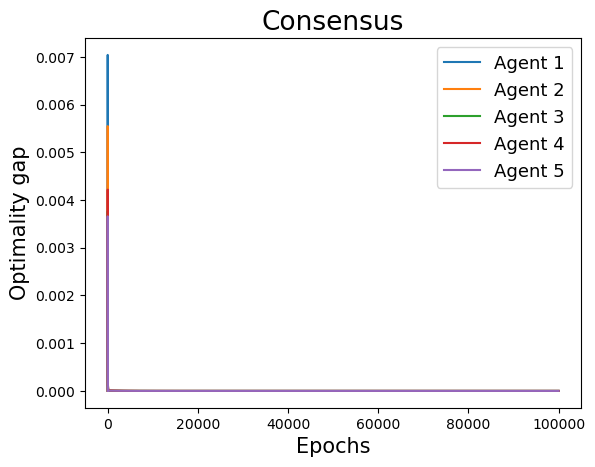

In [216]:
plt.figure()
for i in range(len(A)):
    plt.plot((ecart_alpha_track[:,i]),label="Agent "+str(i+1))
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Optimality gap",fontsize=15)
plt.legend(fontsize=13)
plt.title("Consensus",fontsize=19)

In [209]:
ecart_alpha_agent_track_star=np.zeros((len(ecart_track),len(A)))
for i in range(len(ecart_track)):
    for j in range(len(A)):
        ecart_alpha_agent_track_star[i,j]=np.linalg.norm(alpha_star-ecart_track[i][j,:])

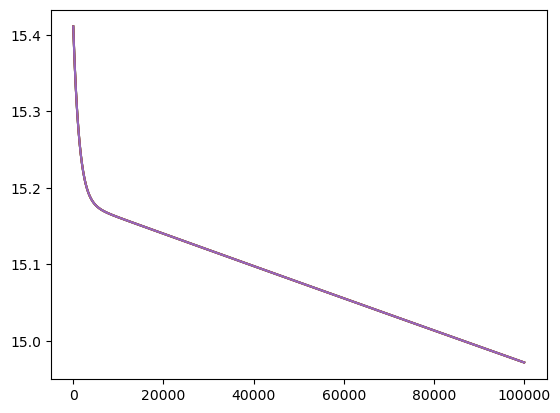

In [215]:
for i in range(5):
    plt.plot(ecart_alpha_agent_track_star[:,i])

In [208]:
ecart_alpha_track_star=np.zeros(len(ecart_track))
for i in range(len(ecart_track)):
    ecart_alpha_track_star[i]=np.linalg.norm(ecart_track[i].mean(axis=0)-alpha_star)

Text(0.5, 1.0, 'Convergence of alpha')

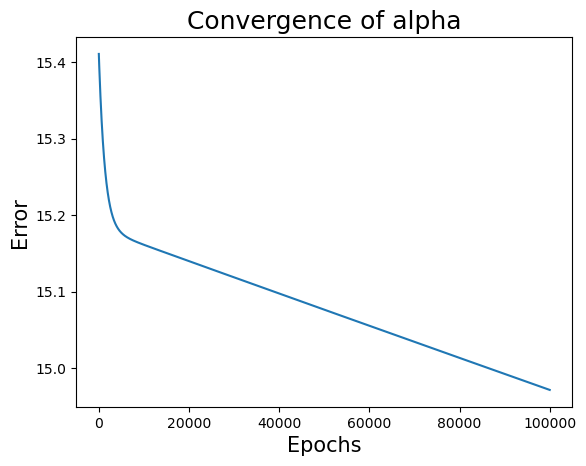

In [170]:


plt.figure()
plt.plot(ecart_alpha_track_star)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Error",fontsize=15)
plt.title("Convergence of alpha",fontsize=18)

In [145]:
W_liste =[W1,W2,W3]
alpha_track_comp=[]
f_track_comp=[]
for W_mat in W_liste: 
    
    alpha_track_w,liste_alpha_track_w,liste_f_track_w=gradient_tracking(alpha0=alpha0,W=W_mat,A=A,M=M,lr=0.95/L,x=x,y=y,alpha_star=alpha_star,n_iter_max=20000)
    alpha_track_comp.append(liste_alpha_track_w)
    f_track_comp.append(liste_f_track_w)
    print(f_a(alpha_track.mean(axis=0),A,sigma,K_mm,K_im,N,y))
    #ecart.append(np.abs(f_a(alpha.mean(axis=0),A,sigma,K_mm,K_im,N,y)-f_a(alpha_star,A,sigma,K_mm,K_im,N,y)))
    

  9%|▊         | 1708/20000 [00:05<01:07, 272.85it/s]C:\Users\pasta\AppData\Local\Temp\ipykernel_17664\3823597306.py:22: RuntimeWarning: overflow encountered in double_scalars
  res+= terme1+terme2
C:\Users\pasta\AppData\Local\Temp\ipykernel_17664\3823597306.py:20: RuntimeWarning: overflow encountered in double_scalars
  terme2=somme/(2*sigma*sigma)
C:\Users\pasta\AppData\Local\Temp\ipykernel_17664\3823597306.py:19: RuntimeWarning: overflow encountered in double_scalars
  somme+=(y[i]-(K_im[N_back[i],:]).dot(alpha))**2
 16%|█▋        | 3287/20000 [00:11<00:58, 285.34it/s]C:\Users\pasta\AppData\Local\Temp\ipykernel_17664\858938228.py:48: RuntimeWarning: overflow encountered in add
  g[a,:]+=grad_f_a(alpha[a,:],A[a],sigma,K_mm,K_im,N,y)-grad_f_a(alpha_pred[a,:],A[a],sigma,K_mm,K_im,N,y)
c:\Users\pasta\Anaconda3\lib\site-packages\numpy\core\_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
100%|██████████| 20

53.08092273358804


100%|██████████| 20000/20000 [01:11<00:00, 278.14it/s]


53.08092273358804


100%|██████████| 20000/20000 [01:17<00:00, 259.71it/s]


53.08092273358804


100%|██████████| 20000/20000 [01:18<00:00, 254.93it/s]

53.08092273358804


Text(0.5, 1.0, 'Convergence for different graph')

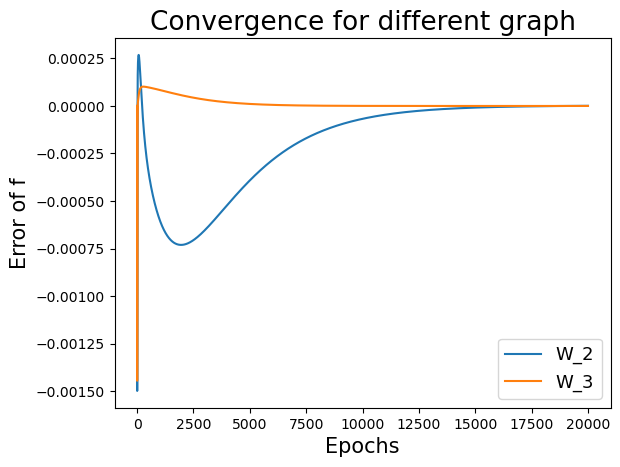

In [155]:
plt.figure()
for i in range(2,4):
    plt.plot(np.array(f_track_comp[i])-np.array(f_track_comp[1]),label="W_"+str(i))
plt.legend(fontsize=13)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Error of f",fontsize=15)
plt.title("Convergence for different graph",fontsize=19)

54.61729339938181
54.771510889925636
54.31219590664071


In [193]:
step_track=[0.1,0.5,0.9,1.3]
track_f_step=[]
track_alpha_step=[]
for step in step_track:
    alpha_track_step,ecart_track_step,ecart_f_track_step=gradient_tracking(alpha0=alpha0,W=W,A=A,M=M,lr=step/L,x=x,y=y,alpha_star=alpha_star,n_iter_max=50000)
    track_f_step.append(ecart_f_track_step)
    alpha_gap_step=np.zeros((len(ecart_track_step),10))
    for i in range(len(ecart_track_step)):
        alpha_gap_step[i,:]=ecart_track_step[i].mean(axis=0)
    track_alpha_step.append(alpha_gap_step)


100%|██████████| 50000/50000 [03:22<00:00, 246.54it/s]


100%|██████████| 10000/10000 [00:47<00:00, 211.15it/s]


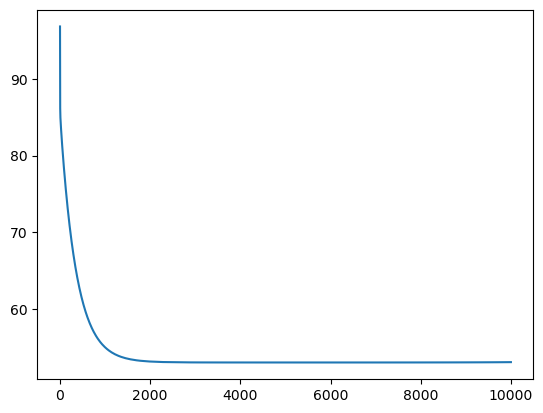

In [221]:
alpha_track_step,ecart_track_step,ecart_f_track_step=gradient_tracking(alpha0=alpha0,W=W,A=A,M=M,lr=3.5/L,x=x,y=y,alpha_star=alpha_star,n_iter_max=10000)
plt.plot(ecart_f_track_step)

In [192]:
alpha_gap_step=np.zeros((len(ecart_track_step),10))
for i in range(len(ecart_track_step)):
    alpha_gap_step[i,:]=ecart_track_step[i].mean(axis=0)


Text(0.5, 1.0, 'Convergence of f for diffent step')

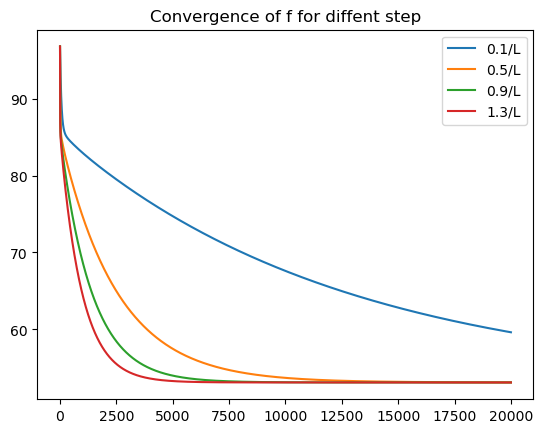

In [178]:
plt.figure()
for i in range(len(track_f_step)):
    plt.plot(track_f_step[i],label=str(step_track[i])+"/L")
plt.legend()
plt.title("Convergence of f for diffent step")

Text(0.5, 1.0, 'Convergence of f for diffent step')

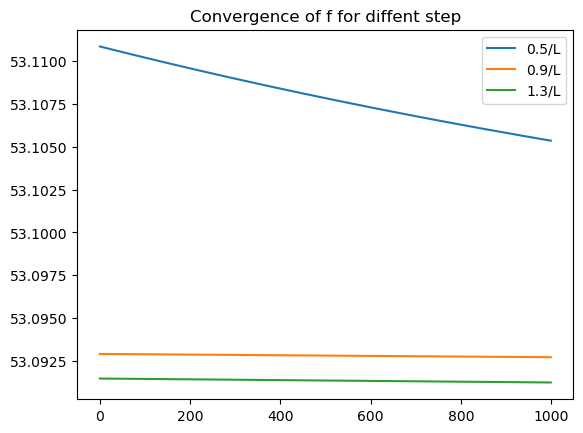

In [180]:
plt.figure()
for i in range(1,len(track_f_step)):
    plt.plot(track_f_step[i],label=str(step_track[i])+"/L")
plt.legend()
plt.title("Convergence of f for diffent step")

Text(0.5, 1.0, 'Convergence of alpha')

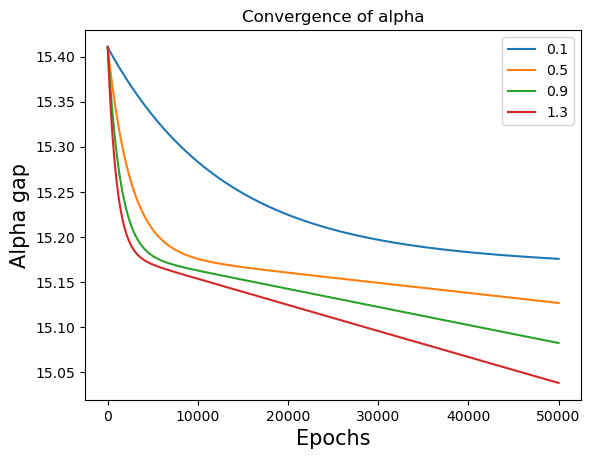

In [201]:
plt.figure()
for i in range(len(track_alpha_step)):
    temp = np.zeros(track_alpha_step[i].shape[0])
    for j in range(track_alpha_step[i].shape[0]):
        temp[j]=np.linalg.norm(track_alpha_step[i][j]-alpha_star)
    plt.plot(temp,label=step_track[i])
plt.legend()
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Alpha gap",fontsize=15)
plt.title("Convergence of alpha")


In [197]:
track_alpha_step[0][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

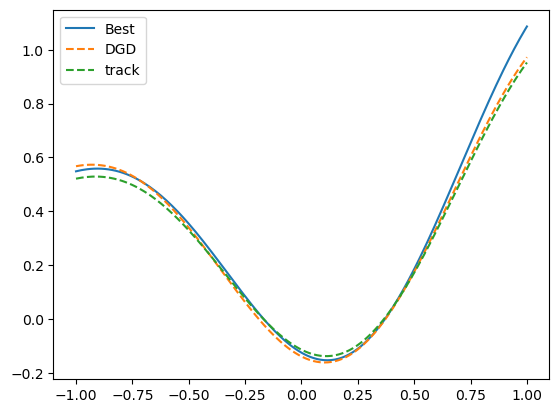

In [ ]:
s=250
x_prime=np.linspace(-1,1,s)

plt.figure()
plt.plot(x_prime,f(x_prime,M,alpha_star),label="Best",)
plt.plot(x_prime,f(x_prime,M,resultat_dgd),label="DGD",linestyle='dashed')
plt.plot(x_prime,f(x_prime,M,resultat_track),label="track",linestyle='dashed')
# i=1
# for A_elem in A : 
#     plt.scatter(x[A_elem],y[A_elem],label="agent "+str(i))
#     i+=1
plt.legend()

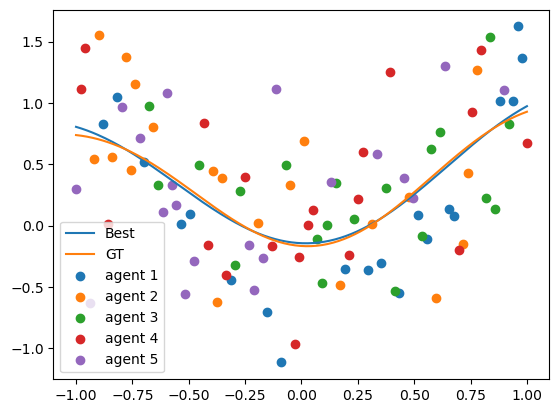

In [332]:
s=250
x_prime=np.linspace(-1,1,s)

plt.figure()
plt.plot(x_prime,f(x_prime,M,alpha_star),label="Best")
plt.plot(x_prime,f(x_prime,M,resultat_track),label="GT")
i=1
for A_elem in A : 
    plt.scatter(x[A_elem],y[A_elem],label="agent "+str(i))
    i+=1
plt.legend()

In [ ]:
print(resultat_dgd)
print(resultat_track)
print(alpha_star)
np.linalg.norm(resultat_dgd-resultat_track)

[ 2.10419569 -0.72430732  0.90271397  0.66149842 -0.26857033 -0.68556019
 -0.7942993  -0.19643902  0.91277775 -0.75573061]
[ 1.7979279  -0.5579655   1.07444178  0.2462408  -0.47905761 -0.56780679
 -0.41247123 -0.4466622   1.02522055 -0.54189686]
[ 1.80033349 -1.33121948  1.63928985 -0.83748248 -0.42244497 -0.00947146
  0.11740051 -0.09430515  1.31833316 -0.88589048]


0.8051970123591953

# Dual Decomposition

In [69]:
def calcul_x_a_star(a,A_elem,lambda_ij,graphe,beta):
    mat=0.2*K_mm+2*beta*np.eye(m)
    vec=np.zeros(m)
    for i in A_elem: 
        mat+=(K_im[N_back[i],:].reshape((-1,1))@K_im[N_back[i],:].reshape((1,-1)))/(sigma*sigma)
        vec+=y[i]*K_im[N_back[i],:]/(sigma*sigma)
    
    # for arete in liste_arete:
    for j in range(5):
        # i,j=arete
        # if i==a or j==a:
        # print((lambda_ij[ind,:]).reshape((1,-1)).shape)
        # print(A_dd[m*ind:m*(ind+1),m*a:m*(a+1)].shape)
        # print((lambda_ij[ind,:]).reshape((1,-1))@A_dd[m*ind:m*(ind+1),m*a:m*(a+1)])
        # vec-=((lambda_ij[ind,:]).reshape((1,-1))@A_dd[m*ind:m*(ind+1),m*a:m*(a+1)]).flatten()
        if graphe[a,j]>0:
            if j<a:
                vec-=lambda_ij[a,j]
            elif a<j:
                vec+=lambda_ij[j,a]

    
    return np.linalg.solve(mat, vec)

In [70]:
def dual_decomposition(W,x,y,m,lr,lambda_0=0,n_iter_max=5000): 
    # matrice A

    #trouver la matrice A
    f_res=[]
    liste_arete=[]
    for i in range(W.shape[0]):
        for j in range(i):
            if W[i,j]>0:
                liste_arete.append([i,j])
    E = len(liste_arete) # nombre d'arrête
    N_w = W.shape[0] # nombre de noeud
    
    A_dd=np.zeros((m*E,m*N_w))

    for e in range(E):
        arete=liste_arete[e]
        A_dd[e*m:(e+1)*m,arete[0]*m:(arete[0]+1)*m] = np.eye(m)
        A_dd[e*m:(e+1)*m,arete[1]*m:(arete[1]+1)*m] = -np.eye(m)
    
    
    graphe=1*(W>0)
    for i in range(5):
        graphe[i,i]=0
    lambda_ij=lambda_0*np.ones((W.shape[0],W.shape[0],m))
    list_x_star = []
    list_x_star_agent = []
    
    for n_iter in tqdm(range(n_iter_max)):
        #calcul de x_i_star pour tous les noeuds
        x_star=np.zeros((5,m))
        for a in range(5):
            
            # x_star[a,:]=calcul_x_a_star(a,lambda_ij,A_dd,liste_arete,A,sigma,K_mm,K_im,N,y,beta=0.005)
            x_star[a,:] = calcul_x_a_star(a,A[a],lambda_ij,graphe,beta=0.001)
        # ind=0
        # for arete in liste_arete:
        #     i,j=arete
        #     lambda_ij[ind,:] += lambda_ij[ind,:]+lr*(x_star[i,:]-x_star[j,:])
        #     ind+=1
        
        # lambda_ij=lambda_ij_next.copy()
        # print(lambda_ij)
        for i in range(5):
            for j in range(i):
                lambda_ij[i,j,:]+=lr*(x_star[i,:]-x_star[j,:])
        
        f_res.append(f_a(x_star.mean(axis=0),A,sigma,K_mm,K_im,N,y))
        list_x_star.append(x_star.mean(axis=0))
        list_x_star_agent.append(x_star)

    return lambda_ij,x_star,f_res, list_x_star, list_x_star_agent


In [72]:
sigma_max=np.sort(np.linalg.eig(W)[0])[-2]

lambda_ij,x_star,f_res,list_x_star, list_x_star_agent=dual_decomposition(W,x,y,m,lr=0.0001,lambda_0=0,n_iter_max=100000)

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [01:50<00:00, 904.42it/s]


In [73]:
def f(x_prime,M,alpha):
    res=np.zeros(x_prime.size)
    for i in range(x_prime.size):
        for j in range(len(M)):
            res[i]+=alpha[j]*k(x_prime[i],x[M[j]])
    
    return res

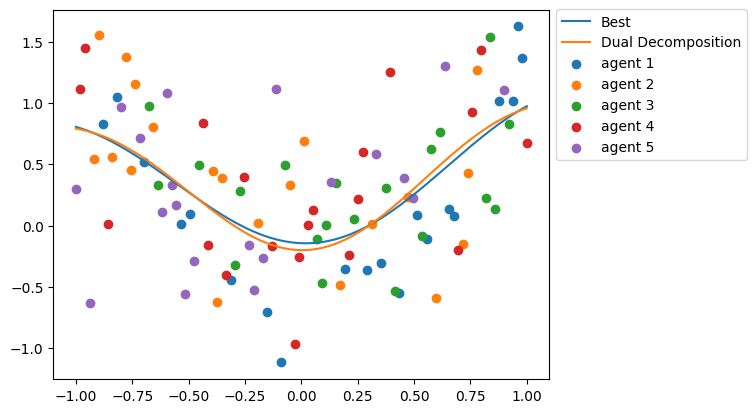

In [74]:
s=250
x_prime=np.linspace(-1,1,s)

plt.figure()
plt.plot(x_prime,f(x_prime,M,alpha_star),label="Best")
plt.plot(x_prime,f(x_prime,M,x_star.mean(axis=0)),label="Dual Decomposition")
i=1
for A_elem in A : 
    plt.scatter(x[A_elem],y[A_elem],label="agent "+str(i))
    i+=1

plt.legend(loc='upper left', bbox_to_anchor=(1, 1.02))

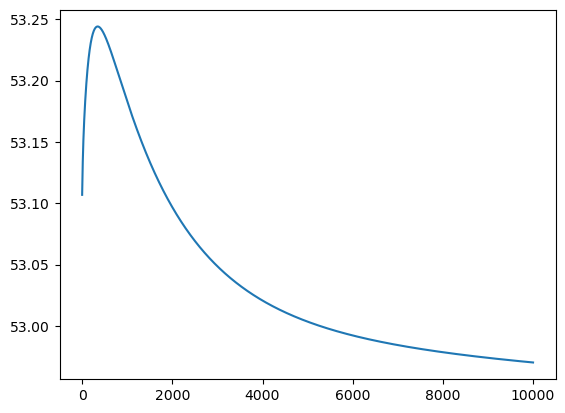

In [ ]:
plt.plot(np.array(f_res))

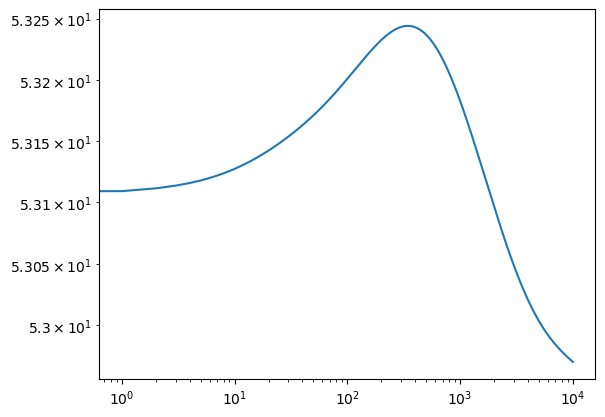

In [ ]:
plt.loglog(np.array(f_res))

In [76]:
ecart_f = []
ecart = []
f_a_star = f_a(alpha_star,A,sigma,K_mm,K_im,N,y)
for i,alpha in enumerate(list_x_star_agent):
    ecart.append([])
    for j in range(list_x_star_agent[0].shape[0]):
        ecart[i].append(np.linalg.norm(alpha[j]-alpha_star))

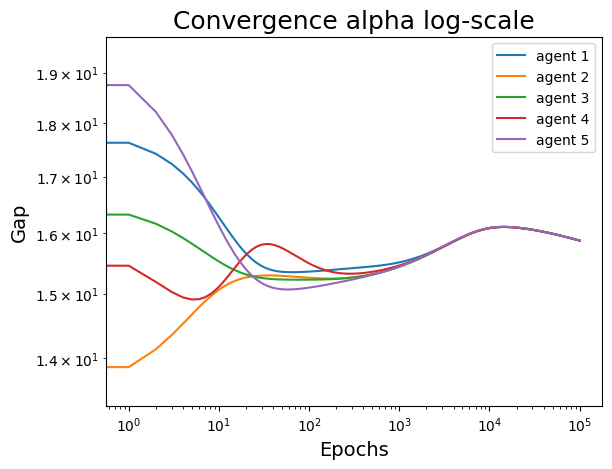

In [77]:
plt.figure()
for a in range(x_star.shape[0]) :  
    res = [ecart[j][a] for j in range(len(ecart))]
    plt.loglog(res, label="agent "+str(a+1))
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Gap",fontsize=14)

plt.title("Convergence alpha log-scale",fontsize=18)
plt.legend()

In [84]:
W_liste =[W0,W1,W2,W3]
alpha_dd_comp=[]
f_dd_comp=[]
for W_mat in W_liste: 
    
    lambda_ij,x_star,f_res,list_x_star, list_x_star_agent=dual_decomposition(W_mat,x,y,m,lr=0.0001,lambda_0=0,n_iter_max=20000)
    alpha_dd_comp.append(list_x_star)
    f_dd_comp.append(f_res)

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:23<00:00, 838.46it/s]


# ADMM

In [88]:
def calcul_x_a_k(a,A_elem,lambda_mat,y_ij,W,beta):
    mat=0.2*K_mm.copy()
    vec=np.zeros(m)
    for i in A_elem: 
        mat+=(K_im[N_back[i],:].reshape((-1,1))@K_im[N_back[i],:].reshape((1,-1)))/(sigma*sigma)
        vec+=y[i]*K_im[N_back[i],:]/(sigma*sigma)

    for j in range(W.shape[0]):
        if W[a,j]>0 and a!=j:
            mat+=beta*np.eye(m)
            vec+=beta*y_ij[a,j,:]-lambda_mat[a,j,:]

    
    
    
    return np.linalg.solve(mat, vec)

In [89]:
def admm(W,x,y,m,beta=100,n_iter_max=5000):
    graphe=W.copy()
    
    for i in range(5):
        graphe[i,i]=0
    
    #initialisation lambda
    lambda_mat=np.zeros((W.shape[0],W.shape[0],m))
    y_ij = np.zeros((W.shape[0],W.shape[0],m))
    res_f=[]
    x_k_liste=[]
    x_k=np.zeros((5,m))
    x_k_liste_agent=[]
    for n_iter in tqdm(range(n_iter_max)):
        for a in range(5):
            x_k[a,:]=calcul_x_a_k(a,A[a],lambda_mat,y_ij,graphe,beta)
            
        for i in range(5):
            for j in range(5):
                if graphe[i,j]>0:
                    y_ij[i,j,:]=(x_k[i,:]+x_k[j,:])/2+lambda_mat[i,j,:]/beta
        x_k_liste.append(x_k.mean(axis=0))
        x_k_liste_agent.append(x_k)
        res_f.append(f_a(x_k.mean(axis=0),A,sigma,K_mm,K_im,N,y))

    return x_k,x_k_liste,res_f,x_k_liste_agent
        

In [90]:
x_admm,alpha_liste_admm,f_liste_admm,x_k_liste_agent=admm(W,x,y,m,beta=100,n_iter_max=100000)

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [02:06<00:00, 792.28it/s]


In [91]:
print(f_a(x_admm.mean(axis=0),A,sigma,K_mm,K_im,N,y))
print(f_a(alpha_star,A,sigma,K_mm,K_im,N,y))

print(x_admm.mean(axis=0))

52.31461665318851
62.62184250735076
[ 0.57566385  1.27872293 -1.56556463  0.41556656 -1.75403612  2.25410254
  1.12015891 -1.66783893 -0.54672786  1.08986391]


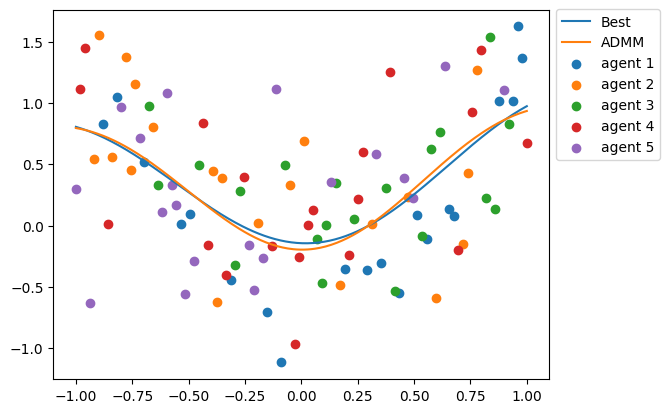

In [92]:
s=250
x_prime=np.linspace(-1,1,s)

plt.figure()
plt.plot(x_prime,f(x_prime,M,alpha_star),label="Best")
plt.plot(x_prime,f(x_prime,M,x_admm.mean(axis=0)),label="ADMM")
i=1
for A_elem in A : 
    plt.scatter(x[A_elem],y[A_elem],label="agent "+str(i))
    i+=1

plt.legend(loc='upper left', bbox_to_anchor=(1, 1.02))

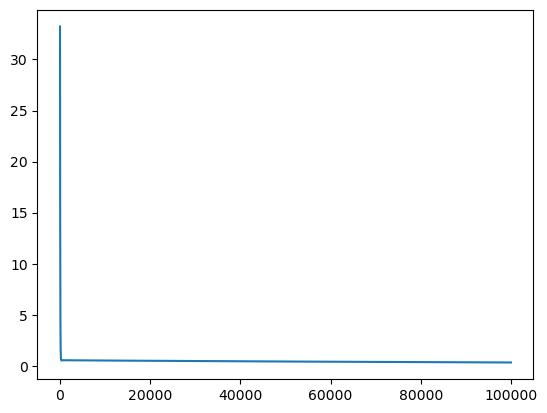

In [328]:
plt.plot(f_liste_admm-f_a(alpha_star,A,sigma,K_mm,K_im,N,y))


In [94]:
W_liste =[W0,W1,W2,W3]
alpha_admm_comp=[]
f_admm_comp=[]
for W_mat in W_liste: 
    
    x_admm,alpha_liste_admm,f_liste_admm,x_k_liste_agent=admm(W_mat,x,y,m,beta=100,n_iter_max=20000)
    alpha_admm_comp.append(alpha_liste_admm)
    f_admm_comp.append(f_liste_admm)

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:25<00:00, 770.97it/s]


Text(0.5, 1.0, 'gap with the first graph')

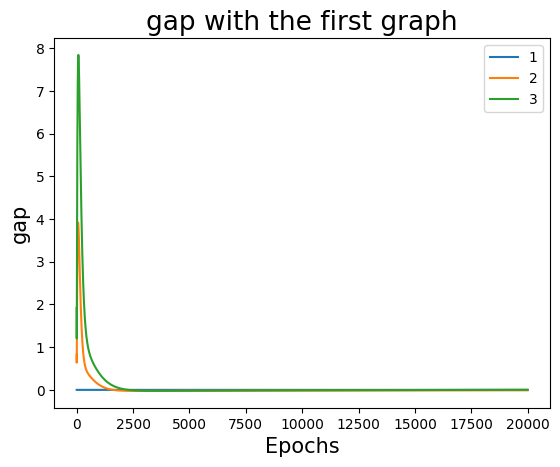

In [95]:
plt.figure()
for i in range(1,len(f_admm_comp)):
    plt.plot(np.array(f_admm_comp[i])-np.array(f_admm_comp[0]),label=str(i))
plt.legend()
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("gap",fontsize=15)
plt.title("gap with the first graph",fontsize=19)

# Part II

# FedAvg

In [65]:
import random

In [67]:
with open('second_database.pkl','rb') as f:
    X, Y = pickle.load(f)

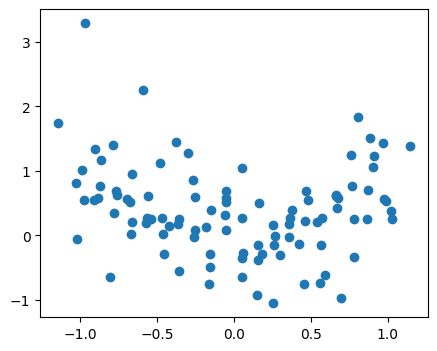

In [68]:
plt.figure(figsize=(5,4))
plt.scatter(X,Y)

In [70]:
x_m_points=np.linspace(-1,1,m)

In [71]:
n = 100
m = 10
a = 5

In [72]:
def K(N,M,x):
    """
    N : ensemble d'indice pour les colonnes
    M : ensemble des indices M
    x: données
    """
    K=np.zeros((len(N),len(M)))
    for i in range(len(N)):
        for j in range(len(M)):
            K[i,j]=k(x[N[i]],x[M[j]])

    return K

In [73]:
Kmm = K(np.arange(x_m_points.shape[0]),np.arange(x_m_points.shape[0]),x_m_points)

In [74]:
Kmm

array([[1.        , 0.95181678, 0.82075481, 0.64118039, 0.45378877,
        0.29096046, 0.16901332, 0.08894358, 0.0424048 , 0.01831564],
       [0.95181678, 1.        , 0.95181678, 0.82075481, 0.64118039,
        0.45378877, 0.29096046, 0.16901332, 0.08894358, 0.0424048 ],
       [0.82075481, 0.95181678, 1.        , 0.95181678, 0.82075481,
        0.64118039, 0.45378877, 0.29096046, 0.16901332, 0.08894358],
       [0.64118039, 0.82075481, 0.95181678, 1.        , 0.95181678,
        0.82075481, 0.64118039, 0.45378877, 0.29096046, 0.16901332],
       [0.45378877, 0.64118039, 0.82075481, 0.95181678, 1.        ,
        0.95181678, 0.82075481, 0.64118039, 0.45378877, 0.29096046],
       [0.29096046, 0.45378877, 0.64118039, 0.82075481, 0.95181678,
        1.        , 0.95181678, 0.82075481, 0.64118039, 0.45378877],
       [0.16901332, 0.29096046, 0.45378877, 0.64118039, 0.82075481,
        0.95181678, 1.        , 0.95181678, 0.82075481, 0.64118039],
       [0.08894358, 0.16901332, 0.2909604

In [75]:
def K_jm(j, x, x_m_points):

    #N : ensemble d'indice pour les colonnes
    #x_m : points de M
    #x: données

    K=np.zeros(x_m_points.shape[0])
    #print(x[j])

    for i,elt in enumerate(x_m_points):
        K[i]= k(elt,x[j])

    return K

In [76]:
def grad_f_a_fedavg(alpha,B, A, sigma,K_mm, x_m_points, y): 
    somme = 1/5*1/10*(K_mm@alpha)
    for j in B:
        #print(j)
        #print(K_jm(j, A, x_m_points).T.shape)
        #print(K_jm(j, A, x_m_points).reshape((10,)).shape)
        somme -= ((y[j]-K_jm(j, A, x_m_points)@alpha))*K_jm(j, A, x_m_points).T/(sigma**2)

    return somme

grad_f_a_fedavg(np.zeros(10),np.arange(X[1].shape[0]),X[1],sigma,K_mm, x_m_points, Y[1])

array([-12.38283979, -13.76583127, -14.62293444, -15.17794162,
       -15.7089893 , -16.35022637, -16.97012808, -17.21288408,
       -16.6865541 , -15.18582013])

In [77]:
def compute_K(X,Y):
    # Computes the matrix K = (k(x,y))
    return np.array([[k(Xi,Yj) for Yj in Y] for Xi in X])

def plot_f(alpha,x_selected,x):
    # Returns the evaluation of the function f defined by alpha at points x
    K = compute_K(x,x_selected)
    return K@alpha

def g(alpha,x_m_points,X,Y,sigma):
    K_mm = compute_K(x_m_points,x_m_points)
    K_nm = compute_K(X.flatten(),x_m_points)
    return alpha.T@K_mm@alpha/2 +  np.linalg.norm(Y.flatten() - K_nm@alpha,ord=2)**2/(2*sigma**2)

In [78]:
B = 10
E = 10
C = 3
max_iter=1000
lr = 0.001

In [89]:
nb_batch = 10
batch_size = len(X[0])//nb_batch
data_client = X[0]
y_client = Y[0]
b = np.random.randint(nb_batch)
batch_x = data_client[b*batch_size:(b+1)*batch_size] if b<len(data_client)//batch_size else X[b*batch_size:]

In [90]:
batch_x

array([1.02386454, 1.14431919])

In [91]:
def FedAvg(X, Y, nb_batch, nb_epoch, alpha0, C, x_m_points, lr, max_iter=1000):
    batch_size = len(X[0])//nb_batch
    X = np.array(X)
    alpha = alpha0
    n_iter = 0
    val_g = []
    while n_iter<max_iter:
        clients = random.sample([i for i in range(len(X))], C)
        client_updates = []
        for i in clients:
            x = alpha
            data_client = X[i]
            y_client = Y[i]
            for e in range(nb_epoch):
                b = np.random.randint(nb_batch)
                batch_x = data_client[b*batch_size:(b+1)*batch_size] if b<len(data_client)//batch_size else X[b*batch_size:]
                #print(batch_x.shape)
                batch_y = y_client[b*batch_size:(b+1)*batch_size]
                grad = grad_f_a_fedavg(alpha, np.arange(batch_size),batch_x,sigma,K_mm, x_m_points, batch_y)
                x -= lr*grad
            client_updates.append(x)
        alpha = np.sum(np.array(client_updates), axis=0)/C
        val_g.append(g(alpha,x_m_points,np.array(X),np.array(Y),sigma))
        n_iter += 1
    return alpha, val_g

In [92]:
alpha_res, val_g = FedAvg(X, Y, B, E, np.zeros(10), 3, x_m_points, lr)
alpha_res

array([ 0.52036359,  0.25641861,  0.62930732,  0.03289981, -0.64867783,
       -0.3315316 , -0.44845509, -0.16407584,  0.2840221 ,  1.16930016])

### Analysis

In [53]:
K_mm = compute_K(x_m_points,x_m_points)
K_nm = compute_K(np.array(X).flatten(),x_m_points)
true_alpha_linalg = np.linalg.solve((sigma**2)*K_mm + K_nm.T@K_nm,K_nm.T@np.array(Y).flatten())

In [54]:
g(true_alpha_linalg,x_m_points,np.array(X),np.array(Y),sigma)

74.6814934080789

Text(0.5, 1.0, 'parameters : B=10, E=10, C=3, max_iter=1000, lr=0.001')

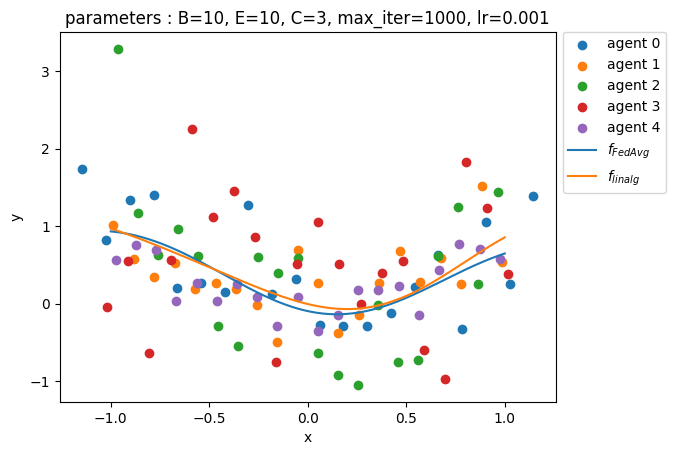

In [55]:
s = 250
x_prime = np.linspace(-1,1,s)
f_approx_fedavg = plot_f(alpha_res,x_m_points,x_prime)
f_true_linalg = plot_f(true_alpha_linalg,x_m_points,x_prime)
for i in range(a) : 
    plt.scatter(X[i],Y[i],label="agent "+str(i))
#plt.plot(X,Y,'bo')
plt.plot(x_prime,f_approx_fedavg, label= "$f_{FedAvg}$")
plt.plot(x_prime,f_true_linalg, label= "$f_{linalg}$")

plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.02))
plt.title("parameters : B="+ str(B)+", E="+str(E)+", C="+ str(C)+ ", max_iter="+ str(max_iter)+", lr="+str(lr))
#plt.savefig("B="+ str(B)+", E="+str(E)+", C="+ str(C)+ ", max_iter="+ str(max_iter)+", lr="+str(lr)+".png", bbox_inches="tight")

In [57]:
g_true = g(true_alpha_linalg,x_m_points,np.array(X),np.array(Y),sigma)

In [58]:
ecart_g = [abs(val_g[i]-g_true) for i in range(len(val_g))]


Text(0.5, 1.0, 'Evolution of the absolute error')

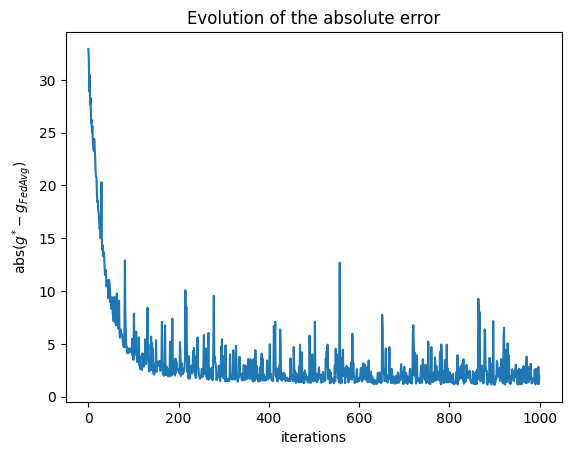

In [59]:
plt.plot(np.arange(max_iter), ecart_g)
plt.ylabel("abs($g^{*}-g_{FedAvg}$)")
plt.xlabel("iterations")
plt.title("Evolution of the absolute error")

### Study of hyperparameters 

Epochs E

In [60]:
res_alpha = []
res_g = []
E_list = [1, 10, 50, 100]
res = []
alpha_list = []

for i,E in enumerate(E_list) :
    alpha_res, val_g= FedAvg(X, Y, B, E, np.zeros(10), 3, x_m_points, lr)
    res.append(val_g)
    alpha_list.append(alpha_res)

In [61]:
ecart_g=[]
for i,E in enumerate(E_list) :
    ecart_g.append([abs(res[i][k]-g_true) for k in range(len(res[i]))])

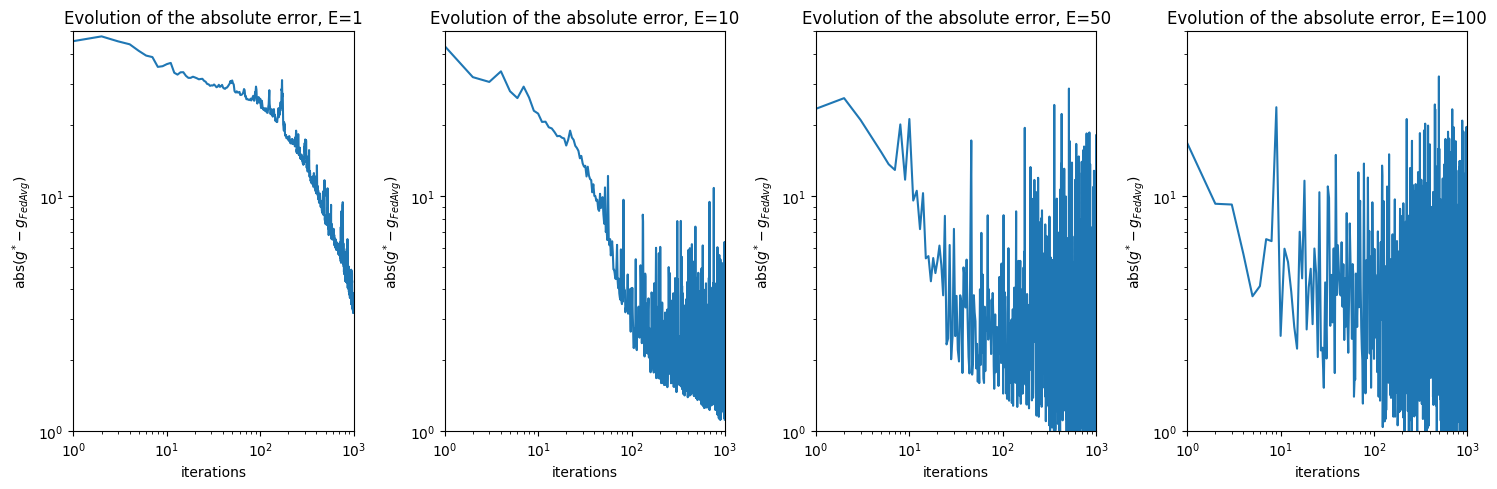

In [62]:
custom_xlim = (1, max_iter)
custom_ylim = (1, 50)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))
for i, ax in enumerate(axes.flat, start=1):
    ax.loglog(np.arange(max_iter), ecart_g[i-1])
    ax.set_ylabel("abs($g^{*}-g_{FedAvg}$)")
    ax.set_xlabel("iterations")
    ax.set_title("Evolution of the absolute error, E="+str(E_list[i-1]))
plt.setp(axes, xlim=custom_xlim, ylim=custom_ylim)
fig.tight_layout()

Clients C

In [63]:

C_list = [1, 2, 3, 4, 5]
res_c = []
alpha_list_c = []

for i,c in enumerate(C_list) :
    alpha_res, val_g= FedAvg(X, Y, 10, 10, np.zeros(10), 3, x_m_points, lr)
    res_c.append(val_g)
    alpha_list_c.append(alpha_res)

In [64]:
ecart_g_c=[]
for i,E in enumerate(C_list) :
    ecart_g_c.append([abs(res_c[i][k]-g_true) for k in range(len(res_c[i]))])

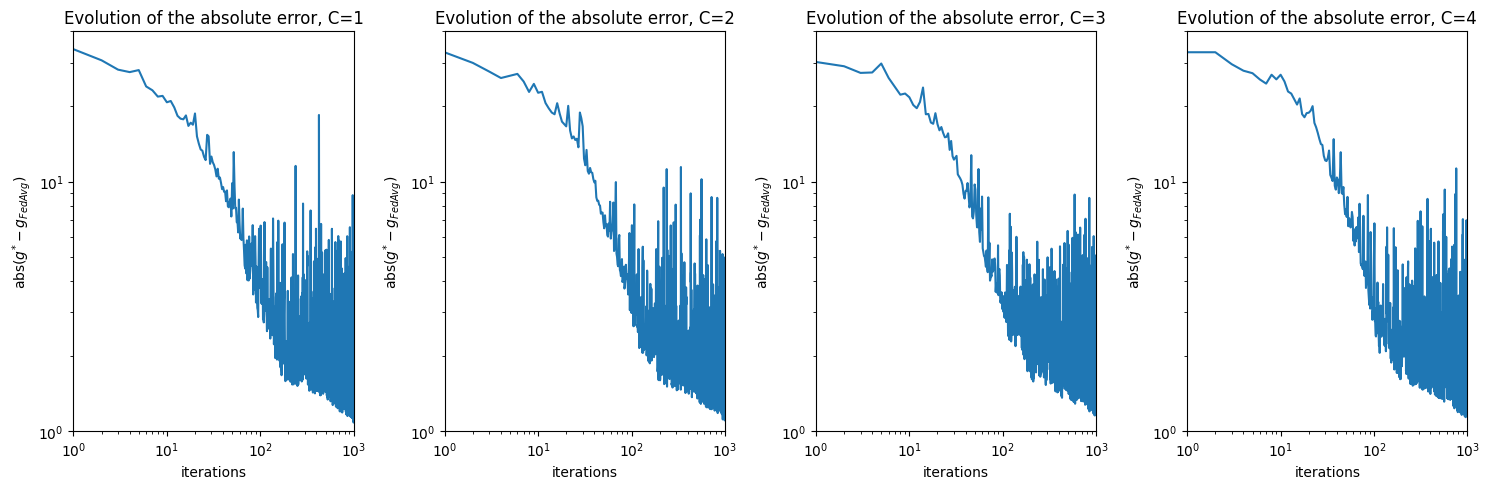

In [65]:
custom_xlim = (1, max_iter)
custom_ylim = (1, 40)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))
for i, ax in enumerate(axes.flat, start=1):
    ax.loglog(np.arange(max_iter), ecart_g_c[i-1])
    ax.set_ylabel("abs($g^{*}-g_{FedAvg}$)")
    ax.set_xlabel("iterations")
    ax.set_title("Evolution of the absolute error, C="+str(C_list[i-1]))
plt.setp(axes, xlim=custom_xlim, ylim=custom_ylim)
fig.tight_layout()

Batch B

In [66]:
b_list = [1, 5, 10, 15]
res_b = []
alpha_list_b = []

for i,b in enumerate(b_list) :
    alpha_res, val_g= FedAvg(X, Y, b, 10, np.zeros(10), 3, x_m_points, lr)
    res_b.append(val_g)
    alpha_list_b.append(alpha_res)

In [67]:
ecart_g_b=[]
for i,E in enumerate(b_list) :
    ecart_g_b.append([abs(res_b[i][k]-g_true) for k in range(len(res_b[i]))])

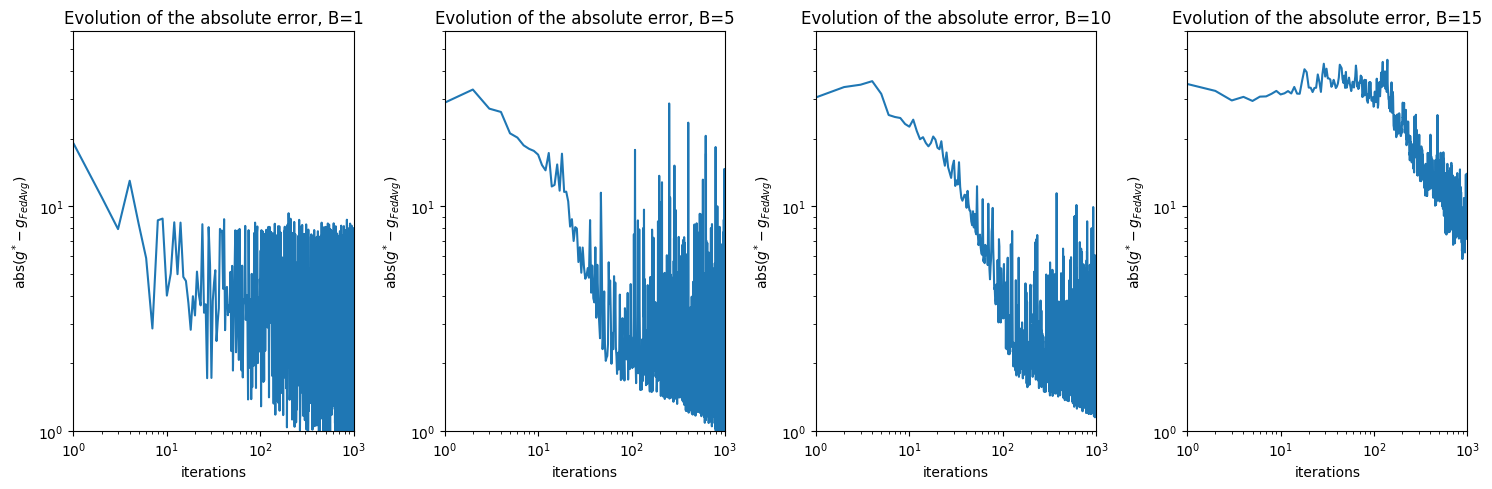

In [68]:
custom_xlim = (1, max_iter)
custom_ylim = (1, 60)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))
for i, ax in enumerate(axes.flat, start=1):
    ax.loglog(np.arange(max_iter), ecart_g_b[i-1])
    ax.set_ylabel("abs($g^{*}-g_{FedAvg}$)")
    ax.set_xlabel("iterations")
    ax.set_title("Evolution of the absolute error, B="+str(b_list[i-1]))
plt.setp(axes, xlim=custom_xlim, ylim=custom_ylim)
fig.tight_layout()

# Part III

# DGD-DP

In [237]:
def gamma_k(k):
    return 1/(k+1)

In [241]:
def DGD_DP(alpha0, W, A,y ,alpha_star,sigma=0.5,  lr=0.1, tol=1e-05,n_iter_max=1000):
    """
    alpha0 : initialisation pour tous les i (matrice) chaque colonne = i
    W : matrice deoublement sto des interactions
    A : matrice des agents
    M : indices des m points
    x : 
    y : 
    alpha_star : meilleur alpha
    lr : pas de la descente (pour l'instant constant)
    tol : amélioration minimale
    n_iter_max : nombre d'itération maximum
    """
    f_a_star=f_a(alpha_star,A,sigma,K_mm,K_im,N,y)
    

    if not is_double_sto(W):
      sys.exit("Matrice W non doublement stochastique")

    W_tilde=W-np.eye(5)

    # initialisation
    alpha = np.copy(alpha0)
 
    # n_iter = 0
    ecart = [np.linalg.norm(alpha.mean(axis=0)-alpha_star)]
    ecart_f=[np.abs(f_a(alpha_star,A,sigma,K_mm,K_im,N,y)-f_a(alpha.mean(axis=0),A,sigma,K_mm,K_im,N,y))]
    f_a_iter=f_a(alpha.mean(axis=0),A,sigma,K_mm,K_im,N,y)
    # pbar = tqdm(range(n_iter_max))
    # for n_iter in pbar:
    #   pbar.set_description(str(f_a(alpha.mean(axis=0),A,sigma,K_mm,K_im,N,y)) )
    t = trange(n_iter_max)
    for n_iter in t:
    # for n_iter in tqdm(range(n_iter_max)):
      t.set_postfix(g_val=f_a_iter)
      alpha_pred=np.copy(alpha)

      # calcul du alpha suivant
      alpha=alpha_pred.copy()
      
      for a in range(len(A)):
        
        alpha[a,:]-=lr*grad_f_a(alpha_pred[a,:],A[a],sigma,K_mm,K_im,N,y)
        for j in range(5):
           if j!=a:
              alpha[a,:]+=gamma_k(n_iter)*W_tilde[a,j]*(alpha_pred[j,:]+np.random.laplace(size=10)-alpha_pred[a,:])
           

      
      #n_iter+=1
      f_a_iter=f_a(alpha.mean(),A,sigma,K_mm,K_im,N,y)
      ecart.append(np.linalg.norm(alpha.mean(axis=0)-alpha_star))
      ecart_f.append(np.abs(f_a_star-f_a_iter))

      # if n_iter > n_iter_max: 
      #   print("Arrêt par itértion")
      #   print("Nombre itération : ",n_iter)
      #   print("Ecart : ", np.linalg.norm(alpha-alpha_pred))
      #   break
      
      
    
    return alpha,ecart,ecart_f
      

        
      
      


In [228]:
alpha0

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [294]:
alpha_dgd_dp,ecart_dgddp,ecart_f_gdgdp=DGD_DP(alpha0, W, A,y ,alpha_star_bis,sigma=0.5,  lr=0.0001, tol=1e-05,n_iter_max=100000)

  0%|          | 0/100000 [00:00<?, ?it/s]

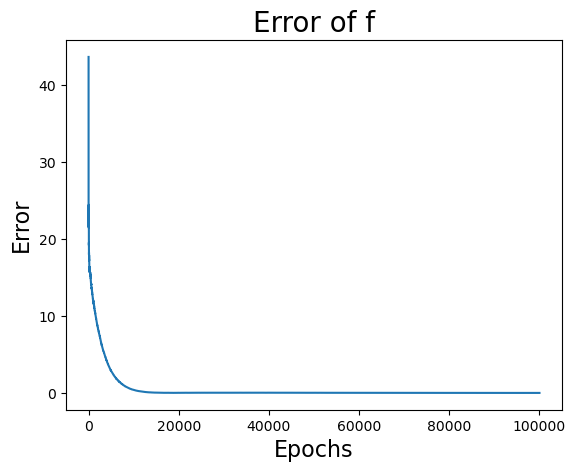

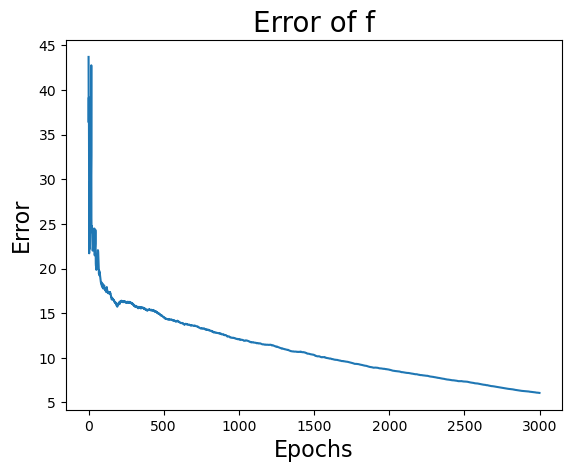

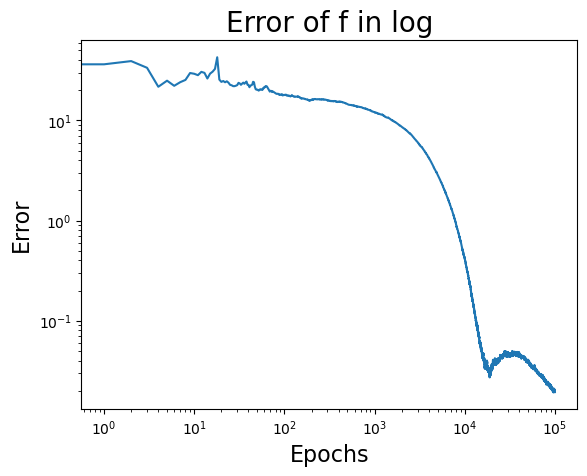

In [295]:
plt.figure()
plt.plot(np.array(ecart_f_gdgdp))
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("Error",fontsize=16)
plt.title("Error of f",fontsize=20)
plt.savefig("gdp_f_error.png")
plt.show()


plt.figure()
plt.plot(np.array(ecart_f_gdgdp)[:3000])
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("Error",fontsize=16)
plt.title("Error of f",fontsize=20)
plt.savefig("gdp_f_error_zoom.png")
plt.show()

plt.figure()
plt.loglog(np.array(ecart_f_gdgdp))
plt.xlabel("Epochs",fontsize=16)
plt.ylabel("Error",fontsize=16)
plt.title("Error of f in log",fontsize=20)
plt.savefig("gdp_f_error_loglog.png")
plt.show()

Text(0.5, 1.0, 'Convergence of alpha')

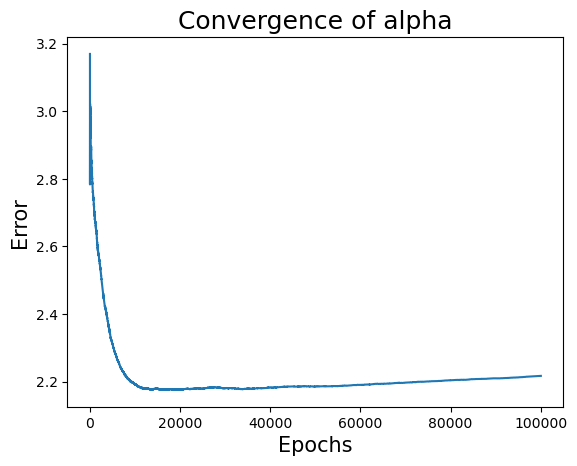

In [298]:


plt.figure()
plt.plot(ecart_dgddp)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Error",fontsize=15)
plt.title("Convergence of alpha",fontsize=18)

In [304]:
def gamma_k_bis(k):
    return 1/(np.power(k+1,0.9))

In [308]:
def lr_k(k):
    return 1/(k+1000)

In [309]:
def DGD_DP_bis(alpha0, W, A,y ,alpha_star,sigma=0.5,  lr=0.1, tol=1e-05,n_iter_max=1000):
    """
    alpha0 : initialisation pour tous les i (matrice) chaque colonne = i
    W : matrice deoublement sto des interactions
    A : matrice des agents
    M : indices des m points
    x : 
    y : 
    alpha_star : meilleur alpha
    lr : pas de la descente (pour l'instant constant)
    tol : amélioration minimale
    n_iter_max : nombre d'itération maximum
    """
    f_a_star=f_a(alpha_star,A,sigma,K_mm,K_im,N,y)
    

    if not is_double_sto(W):
      sys.exit("Matrice W non doublement stochastique")

    W_tilde=W-np.eye(5)

    # initialisation
    alpha = np.copy(alpha0)
 
    # n_iter = 0
    ecart = [np.linalg.norm(alpha.mean(axis=0)-alpha_star)]
    ecart_f=[np.abs(f_a(alpha_star,A,sigma,K_mm,K_im,N,y)-f_a(alpha.mean(axis=0),A,sigma,K_mm,K_im,N,y))]
    f_a_iter=f_a(alpha.mean(axis=0),A,sigma,K_mm,K_im,N,y)
    # pbar = tqdm(range(n_iter_max))
    # for n_iter in pbar:
    #   pbar.set_description(str(f_a(alpha.mean(axis=0),A,sigma,K_mm,K_im,N,y)) )
    t = trange(n_iter_max)
    for n_iter in t:
    # for n_iter in tqdm(range(n_iter_max)):
      t.set_postfix(g_val=f_a_iter)
      alpha_pred=np.copy(alpha)

      # calcul du alpha suivant
      alpha=alpha_pred.copy()
      
      for a in range(len(A)):
        
        alpha[a,:]-=lr_k(n_iter)*grad_f_a(alpha_pred[a,:],A[a],sigma,K_mm,K_im,N,y)
        for j in range(5):
           if j!=a:
              alpha[a,:]+=gamma_k(n_iter)*W_tilde[a,j]*(alpha_pred[j,:]+np.random.laplace(size=10)-alpha_pred[a,:])
           

      
      #n_iter+=1
      f_a_iter=f_a(alpha.mean(axis=0),A,sigma,K_mm,K_im,N,y)
      ecart.append(np.linalg.norm(alpha.mean(axis=0)-alpha_star))
      ecart_f.append(np.abs(f_a_star-f_a_iter))

      # if n_iter > n_iter_max: 
      #   print("Arrêt par itértion")
      #   print("Nombre itération : ",n_iter)
      #   print("Ecart : ", np.linalg.norm(alpha-alpha_pred))
      #   break
      
      
    
    return alpha,ecart,ecart_f
      

        
      
      


In [318]:
alpha_dgd_dp_bis,ecart_dgddp_bis,ecart_f_gdgdp_bis=DGD_DP(alpha0, W3, A,y ,alpha_star_bis,sigma=0.5,  lr=0.0001, tol=1e-05,n_iter_max=100000)

  0%|          | 0/100000 [00:00<?, ?it/s]

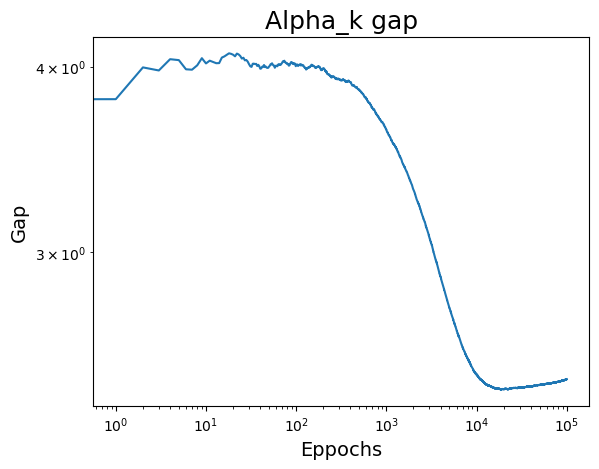

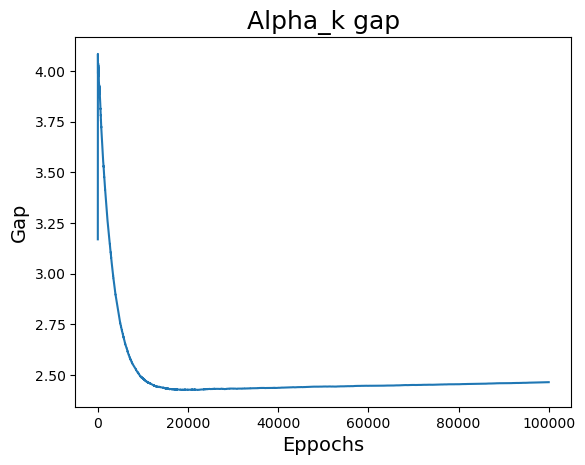

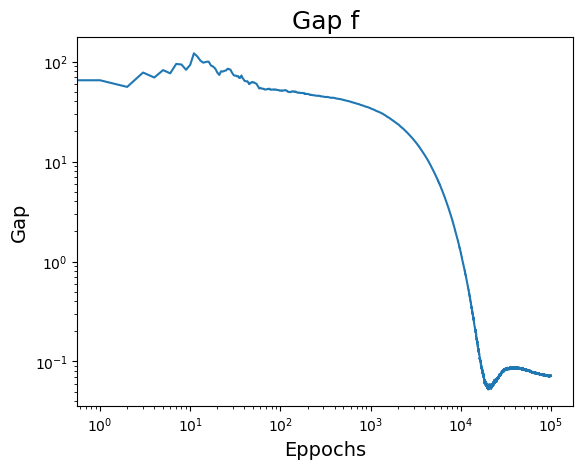

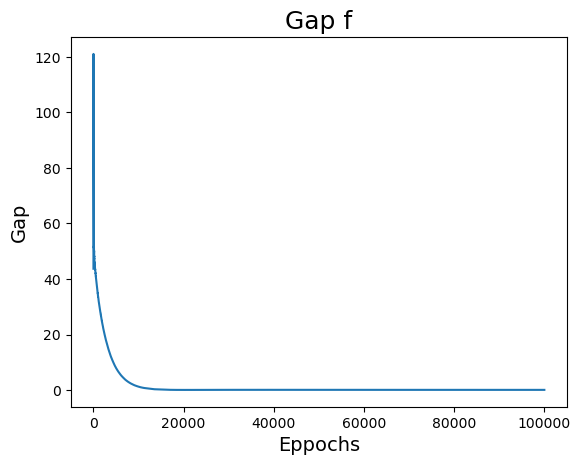

In [323]:
plt.figure()
plt.loglog(ecart_dgddp_bis)
plt.xlabel("Eppochs",fontsize=14)
plt.ylabel("Gap",fontsize=14)
plt.title("Alpha_k gap",fontsize=18)
plt.savefig("dgddp_alpha_log.png")

plt.figure()
plt.plot(ecart_dgddp_bis)
plt.xlabel("Eppochs",fontsize=14)
plt.ylabel("Gap",fontsize=14)
plt.title("Alpha_k gap",fontsize=18)
plt.savefig("dgddp_alpha.png")

plt.figure()
plt.loglog(ecart_f_gdgdp_bis)
plt.xlabel("Eppochs",fontsize=14)
plt.ylabel("Gap",fontsize=14)
plt.title("Gap f",fontsize=18)
plt.savefig("dgddp_f_log.png")

plt.figure()
plt.plot(ecart_f_gdgdp_bis)
plt.xlabel("Eppochs",fontsize=14)
plt.ylabel("Gap",fontsize=14)
plt.title("Gap f",fontsize=18)
plt.savefig("dgddp_f.png")

# Comparaison

In [344]:
print(f_a(alpha_star,A,sigma,K_mm,K_im,N,y))
print(f_a(x_admm.mean(axis=0),A,sigma,K_mm,K_im,N,y))
print(f_a(alpha_dgd_dp_bis.mean(axis=0),A,sigma,K_mm,K_im,N,y))

52.585715162326125
52.796141673192906
53.163717648624235


[]

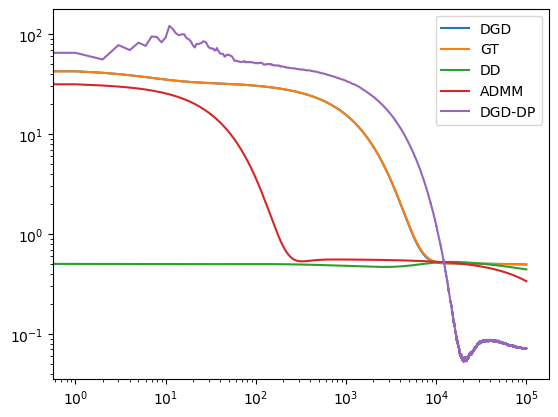

In [331]:
plt.figure()
plt.loglog(np.array(liste_f_dgd)-f_a_copie(alpha_star,A,0.5,M,x,y),label="DGD")
plt.loglog(np.array(ecart_f_track)-f_a_copie(alpha_star,A,0.5,M,x,y),label="GT")
plt.loglog(np.array(f_res)-f_a_copie(alpha_star,A,0.5,M,x,y),label="DD")
plt.loglog(f_liste_admm-f_a(alpha_star,A,sigma,K_mm,K_im,N,y),label="ADMM")
plt.loglog(ecart_f_gdgdp_bis,label="DGD-DP")
plt.legend()
plt.plot()



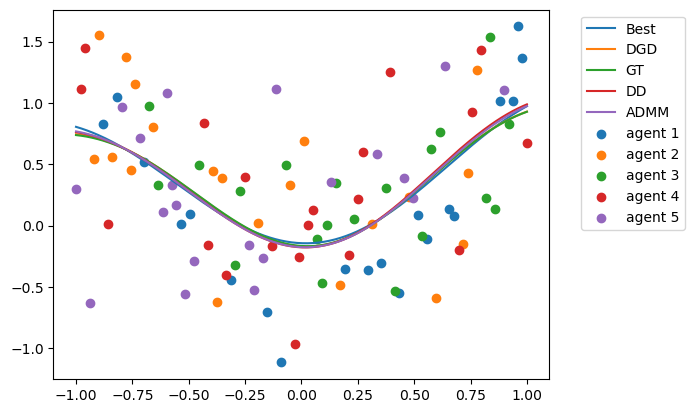

In [337]:
s=250
x_prime=np.linspace(-1,1,s)

plt.figure()
plt.plot(x_prime,f(x_prime,M,alpha_star),label="Best")
plt.plot(x_prime,f(x_prime,M,resultat_dgd),label="DGD")
plt.plot(x_prime,f(x_prime,M,resultat_track),label="GT")
plt.plot(x_prime,f(x_prime,M,x_star.mean(axis=0)),label="DD")
plt.plot(x_prime,f(x_prime,M,x_admm.mean(axis=0)),label="ADMM")
i=1
for A_elem in A : 
    plt.scatter(x[A_elem],y[A_elem],label="agent "+str(i))
    i+=1
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')